In [1]:
import sys
sys.path.append("../src")
from utils.common.pathManager import FilePath
from collections import defaultdict
from shapely import wkt
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from cv2 import imread
import pandas as pd


In [2]:
def build_weights_table(out_path : FilePath) -> pd.DataFrame:
    w_json = out_path.join("train_weights.json")
    w_dict = w_json.read_json()
    w_dict = w_dict.get("dmg", w_dict)
    w_row = [[cls_name, round(wei)] for cls_name, wei in w_dict.items()]
    return  pd.DataFrame(w_row, columns=["Class","Weight"])

def build_conf_table(out_path : FilePath):
    conf_json = out_path.join("conf_list.json")
    conf_list : dict = conf_json.read_json()
    rows = []
    for i, param_dict in conf_list:
        row = [f"Config {i}",param_dict["batch_size"],param_dict["learning_rate"],param_dict["tot_epochs"]]
        rows.append(row)
    return pd.DataFrame(rows, columns=["Number","Batch size","Learning rate","Total epochs"])

def load_dfs(metric_dir : FilePath) -> tuple[pd.DataFrame]:
    bld_df = pd.read_csv(metric_dir.join("val_bld_pixel_level.csv"))
    bld_df = bld_df.set_index(["epoch","class"])
    dmg_df = pd.read_csv(metric_dir.join("val_dmg_pixel_level.csv"))
    dmg_df = dmg_df.set_index(["epoch","class"])
    loss_df = pd.read_csv(metric_dir.join("val_loss.csv"))
    loss_df = loss_df.set_index(["epoch"])
    return bld_df, dmg_df, loss_df

def build_fold_table(out_path : FilePath):
    config_folders = [fol_name for fol_name in out_path.get_folder_names() if fol_name.startswith("config")]
    fold_list = []
    for dir in config_folders:
        conf_path = out_path.join(dir)
        for fold in conf_path.get_folder_names():
            fold_dir = conf_path.join(fold)
            metric_dir = fold_dir.join("metrics/csv")
            bld_df, dmg_df, loss_df = load_dfs(metric_dir)
            c = dir[len(dir)-1]
            f = fold[len(fold)-1]
            best_f1_hm = dmg_df["f1_harmonic_mean"].max()
            best_epoch = dmg_df["f1_harmonic_mean"].idxmax()[0]
            val_loss = loss_df.loc[best_epoch].iloc[0]
            seg_f1 = bld_df.loc[best_epoch,"f1"].iloc[0]
            row = [f"C{c}", f"F{f}", best_epoch, best_f1_hm, val_loss, seg_f1]
            fold_list.append(row)

    fold_df = pd.DataFrame(fold_list, columns=["Conf", "Fold", "Best epoch", "Harmonic-mean-f1", "val-loss", "Seg-f1"])
    fold_df = fold_df.sort_values(by=["Conf"])
    return fold_df


def plot_loss(tr_l: pd.DataFrame, vl_l: pd.DataFrame, step):
    # Renombrar las columnas para evitar confusiones
    tr_l = tr_l.rename(columns={"loss": "train_loss"})
    vl_l = vl_l.rename(columns={"loss": "val_loss"})
    f_df = pd.concat([tr_l, vl_l], axis=1)

    # Crear la figura y el eje, ajustando el tamaño
    fig, ax = plt.subplots(figsize=(10, 6), dpi=150)
    
    # Graficar las pérdidas de entrenamiento y validación
    ax.plot(f_df.index, f_df["train_loss"], label="Train Loss", linewidth=2)
    ax.plot(f_df.index, f_df["val_loss"], label="Validation Loss", linestyle='--', linewidth=2)
    
    # Título y etiquetas con fuentes más grandes
    #ax.set_title("Pérdida a lo largo de las épocas", fontsize=24)
    ax.set_xlabel('Epoch', fontsize=24)
    ax.set_ylabel('Loss', fontsize=24)
    
    # Aumentar el tamaño de la leyenda
    ax.legend(fontsize=24, loc="upper right", fancybox=True, framealpha=1, shadow=True, borderpad=1)
    
    ax.set_xticks(range(0, f_df.index.max()+1, step))

    # Añadir cuadrícula
    ax.grid(True)
    ax.tick_params(axis='both', which='major', labelsize=20)
    plt.show()

def plot_harmonic_mean(tr_m: pd.DataFrame, vl_m: pd.DataFrame, step):
    # Filtrar y procesar los datos de entrenamiento y validación para la clase 0
    tr = tr_m[tr_m["class"] == 0][["epoch","f1_harmonic_mean"]]
    tr = tr.rename(columns={"f1_harmonic_mean": "f1_h_train"})
    tr = tr.set_index("epoch")
    
    vl = vl_m[vl_m["class"] == 0][["epoch","f1_harmonic_mean"]]
    vl = vl.rename(columns={"f1_harmonic_mean": "f1_h_val"})
    vl = vl.set_index("epoch")
    
    # Concatenar los datos de entrenamiento y validación
    metrics_df = pd.concat([tr, vl], axis=1)
    
    # Crear la figura y el eje
    fig, ax = plt.subplots(figsize=(10, 6), dpi=150)

    # Graficar cada conjunto de datos por separado
    ax.plot(metrics_df.index, metrics_df['f1_h_train'], label='HMF1 de Entrenamiento', color='blue', linewidth=2)
    ax.plot(metrics_df.index, metrics_df['f1_h_val'], label='HMF1 de Validación', color='orange', linestyle='--', linewidth=2)
    
    # Configuración de título y etiquetas en español
    #ax.set_title('Media Armónica del F1 a lo largo de las Épocas', fontsize=18)
    ax.set_xlabel('Epoch', fontsize=20)
    ax.set_ylabel('F1 Harmonic Mean', fontsize=20)
    
    # Asegurar que el eje X use números enteros
    ax.set_xticks(range(0, tr_m["epoch"].max()+1, step))

    # Aumentar el tamaño de la leyenda y configurarla adecuadamente
    ax.legend(fontsize=18, loc="upper left", fancybox=True, framealpha=1, shadow=True, borderpad=1)

    # Aumentar el tamaño de las marcas en los ejes
    ax.tick_params(axis='both', which='major', labelsize=20)
    
    # Mostrar cuadrícula
    ax.grid(True)
    
    # Mostrar la gráfica
    plt.show()

def plot_metric_per_class(tr_m: pd.DataFrame, metric: str, step):
    # Crear instancia de LabelDict
    label_dict = LabelDict()

    # Convertir números de clase en nombres de clase
    tr_m['class'] = tr_m['class'].apply(lambda x: label_dict.get_key_by_num(int(x)))

    # Pivotar los datos para tener épocas como índice y clases como columnas
    tr = tr_m.pivot(index='epoch', columns='class', values=metric)
    
    # puedes personalizar estos colores
    colors = ['#0f0f0f', '#ff1e1e', '#2ca02c', '#ffa500', '#808080']  

    # Crear la figura y el eje con un DPI mejorado para mayor calidad
    fig, ax = plt.subplots(figsize=(12, 6), dpi=150)
    
    # Graficar cada clase con un color y estilo de línea diferente
    for i, col in enumerate(tr.columns):
        ax.plot(tr.index, tr[col], label=col, linewidth=2, color=colors[i % len(colors)])
    
    # Configuración de título y etiquetas en español
    #ax.set_title(f'{metric.capitalize()} por Clase a lo Largo de las Épocas', fontsize=18)
    ax.set_xlabel('Epoch', fontsize=14)
    ax.set_ylabel(f'{metric.capitalize()}', fontsize=14)
    
    # Configuración de la leyenda
    ax.legend(fontsize=14, loc='best', fancybox=True, framealpha=1, shadow=True, borderpad=1)
    
    # Asegurar que el eje X use números enteros
    ax.set_xticks(range(0, tr_m["epoch"].max()+1, step))
    
    # Aumentar el tamaño de las marcas en los ejes
    ax.tick_params(axis='both', which='major', labelsize=12)
    
    # Mostrar cuadrícula
    ax.grid(True)
    
    # Mostrar la gráfica
    plt.tight_layout()  # Ajustar automáticamente el diseño para que no se solapen elementos
    plt.show()


# Experiment 1

In [3]:
path = FilePath("/home/mrtc101/Desktop/tesina/repo/prev_outs/exps/exp1_mendieta/out")


In [4]:
wei_df = build_weights_table(path)
wei_df

,Class,Weight
0,destroyed,15432
1,major-damage,890
2,minor-damage,230
3,no-damage,1


In [5]:
#pd.DataFrame.to_latex(index=False)
print(wei_df.to_latex(index=False))

\begin{tabular}{lr}
\toprule
Class & Weight \\
\midrule
destroyed & 15432 \\
major-damage & 890 \\
minor-damage & 230 \\
no-damage & 1 \\
\bottomrule
\end{tabular}



In [6]:
params_df = build_conf_table(path)
params_df

,Number,Batch size,Learning rate,Total epochs
0,Config 0,16,0.0010,20
1,Config 1,16,0.0001,20
2,Config 2,32,0.0010,20
3,Config 3,32,0.0001,20


In [7]:
print(params_df.to_latex(index=False))

\begin{tabular}{lrrr}
\toprule
Number & Batch size & Learning rate & Total epochs \\
\midrule
Config 0 & 16 & 0.001000 & 20 \\
Config 1 & 16 & 0.000100 & 20 \\
Config 2 & 32 & 0.001000 & 20 \\
Config 3 & 32 & 0.000100 & 20 \\
\bottomrule
\end{tabular}



In [8]:
fold_df = build_fold_table(path)
fold_df

,Conf,Fold,Best epoch,Harmonic-mean-f1,val-loss,Seg-f1
6,C0,F0,15,0.021882,0.117259,0.991156
7,C0,F1,17,0.025790,0.117674,0.981068
2,C1,F0,18,0.017753,0.118766,0.981230
3,C1,F1,20,0.009313,0.123948,0.989066
4,C2,F0,7,0.017405,0.065632,0.939596
5,C2,F1,6,0.018700,0.064152,0.978352
0,C3,F0,13,0.021141,0.063781,0.983212
1,C3,F1,19,0.027858,0.070063,0.953690


In [9]:
print(fold_df.to_latex(index=False))

\begin{tabular}{llrrrr}
\toprule
Conf & Fold & Best epoch & Harmonic-mean-f1 & val-loss & Seg-f1 \\
\midrule
C0 & F0 & 15 & 0.021882 & 0.117259 & 0.991156 \\
C0 & F1 & 17 & 0.025790 & 0.117674 & 0.981068 \\
C1 & F0 & 18 & 0.017753 & 0.118766 & 0.981230 \\
C1 & F1 & 20 & 0.009313 & 0.123948 & 0.989066 \\
C2 & F0 & 7 & 0.017405 & 0.065632 & 0.939596 \\
C2 & F1 & 6 & 0.018700 & 0.064152 & 0.978352 \\
C3 & F0 & 13 & 0.021141 & 0.063781 & 0.983212 \\
C3 & F1 & 19 & 0.027858 & 0.070063 & 0.953690 \\
\bottomrule
\end{tabular}



In [10]:
def_metric_dir = path.join("definitive_model/metrics")
def_metric_dir

'/home/mrtc101/Desktop/tesina/repo/prev_outs/exps/exp1_mendieta/out/definitive_model/metrics'

In [11]:
bld_df, dmg_df, loss_df = load_dfs(def_metric_dir.join("csv/"))
best_f1_hm = dmg_df["f1_harmonic_mean"].max()
best_epoch = dmg_df["f1_harmonic_mean"].idxmax()[0]
val_loss = loss_df.loc[best_epoch].iloc[0]
seg_f1 = bld_df.loc[best_epoch,"f1"].iloc[0]
print(best_epoch, best_f1_hm, val_loss, seg_f1)

18 0.0362563056538613 0.1037084615616488 0.9921852442456917


### validation metrics

In [12]:
loss_df.loc[[best_epoch]]

,loss
epoch,
18,0.103708


In [13]:
print(loss_df.loc[[best_epoch]].to_latex())

\begin{tabular}{lr}
\toprule
 & loss \\
epoch &  \\
\midrule
18 & 0.103708 \\
\bottomrule
\end{tabular}



In [14]:
bld_df.loc[best_epoch]

,f1_harmonic_mean,precision,recall,f1,accuracy
class,,,,,
1,0.992185,1.0,0.984492,0.992185,0.994517


In [15]:
print(bld_df.loc[best_epoch].to_latex())

\begin{tabular}{lrrrrr}
\toprule
 & f1_harmonic_mean & precision & recall & f1 & accuracy \\
class &  &  &  &  &  \\
\midrule
1 & 0.992185 & 1.000000 & 0.984492 & 0.992185 & 0.994517 \\
\bottomrule
\end{tabular}



In [16]:
dmg_df.loc[best_epoch]

,f1_harmonic_mean,precision,recall,f1,accuracy
class,,,,,
0,0.036256,0.004456,0.468629,0.008828,0.577399
1,0.036256,0.998532,0.628725,0.771608,0.894768
2,0.036256,0.034158,0.973281,0.065999,0.941778
3,0.036256,0.152787,0.932629,0.262561,0.996714
4,0.036256,0.168154,0.356641,0.228548,0.999899


In [17]:
print(dmg_df.loc[best_epoch].to_latex())

\begin{tabular}{lrrrrr}
\toprule
 & f1_harmonic_mean & precision & recall & f1 & accuracy \\
class &  &  &  &  &  \\
\midrule
0 & 0.036256 & 0.004456 & 0.468629 & 0.008828 & 0.577399 \\
1 & 0.036256 & 0.998532 & 0.628725 & 0.771608 & 0.894768 \\
2 & 0.036256 & 0.034158 & 0.973281 & 0.065999 & 0.941778 \\
3 & 0.036256 & 0.152787 & 0.932629 & 0.262561 & 0.996714 \\
4 & 0.036256 & 0.168154 & 0.356641 & 0.228548 & 0.999899 \\
\bottomrule
\end{tabular}



# Plot metrics over validation

In [18]:
def_metric_dir = path.join("definitive_model/metrics/csv")

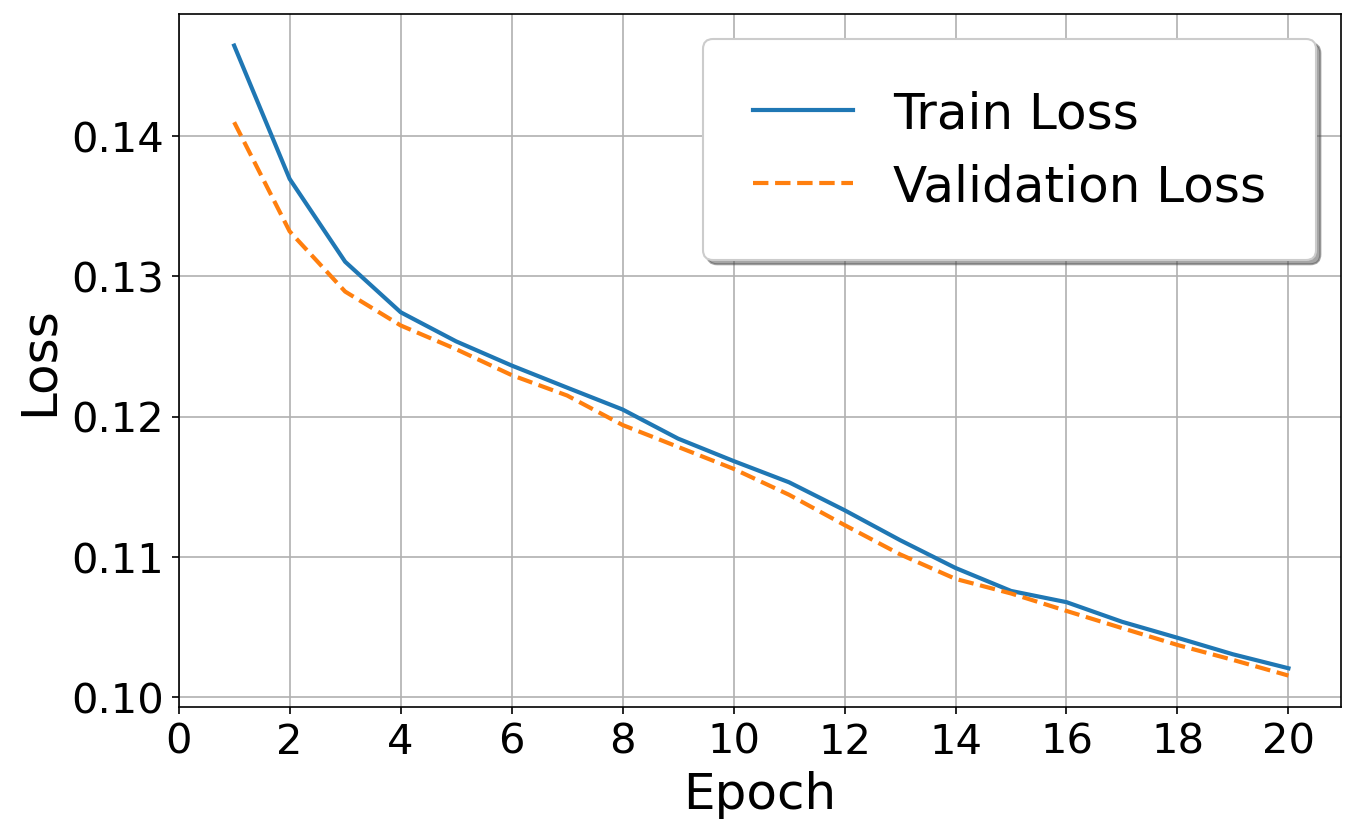

In [19]:

#loss_plots
loss_train_df = pd.read_csv(def_metric_dir.join("train_loss.csv"))
loss_train_df = loss_train_df.set_index("epoch")

loss_val_df = pd.read_csv(def_metric_dir.join("val_loss.csv"))
loss_val_df = loss_val_df.set_index("epoch")

plot_loss(loss_train_df, loss_val_df,2)


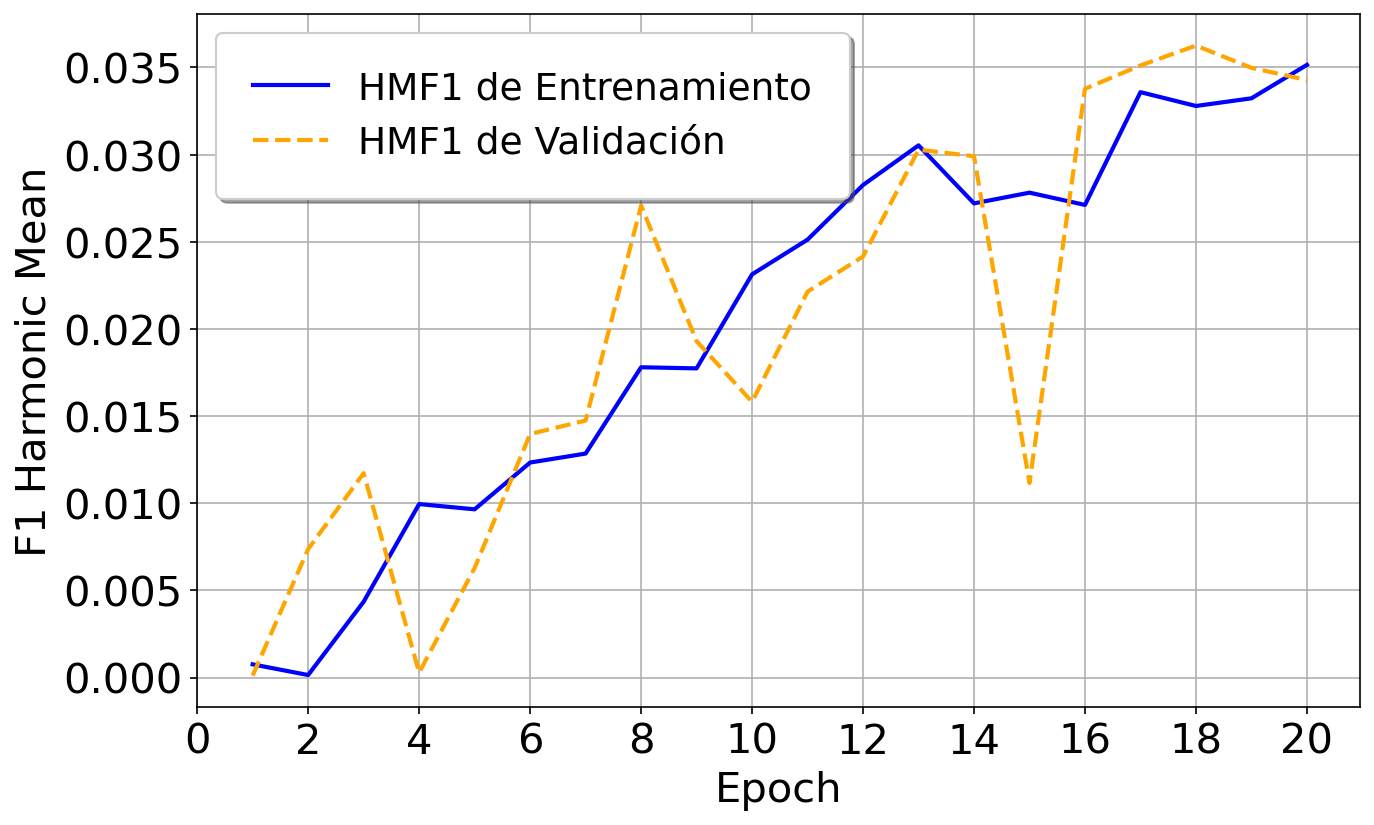

In [20]:
dmg_train_df = pd.read_csv(def_metric_dir.join("train_dmg_pixel_level.csv"))
dmg_val_df = pd.read_csv(def_metric_dir.join("val_dmg_pixel_level.csv"))

plot_harmonic_mean(dmg_train_df, dmg_val_df,2)

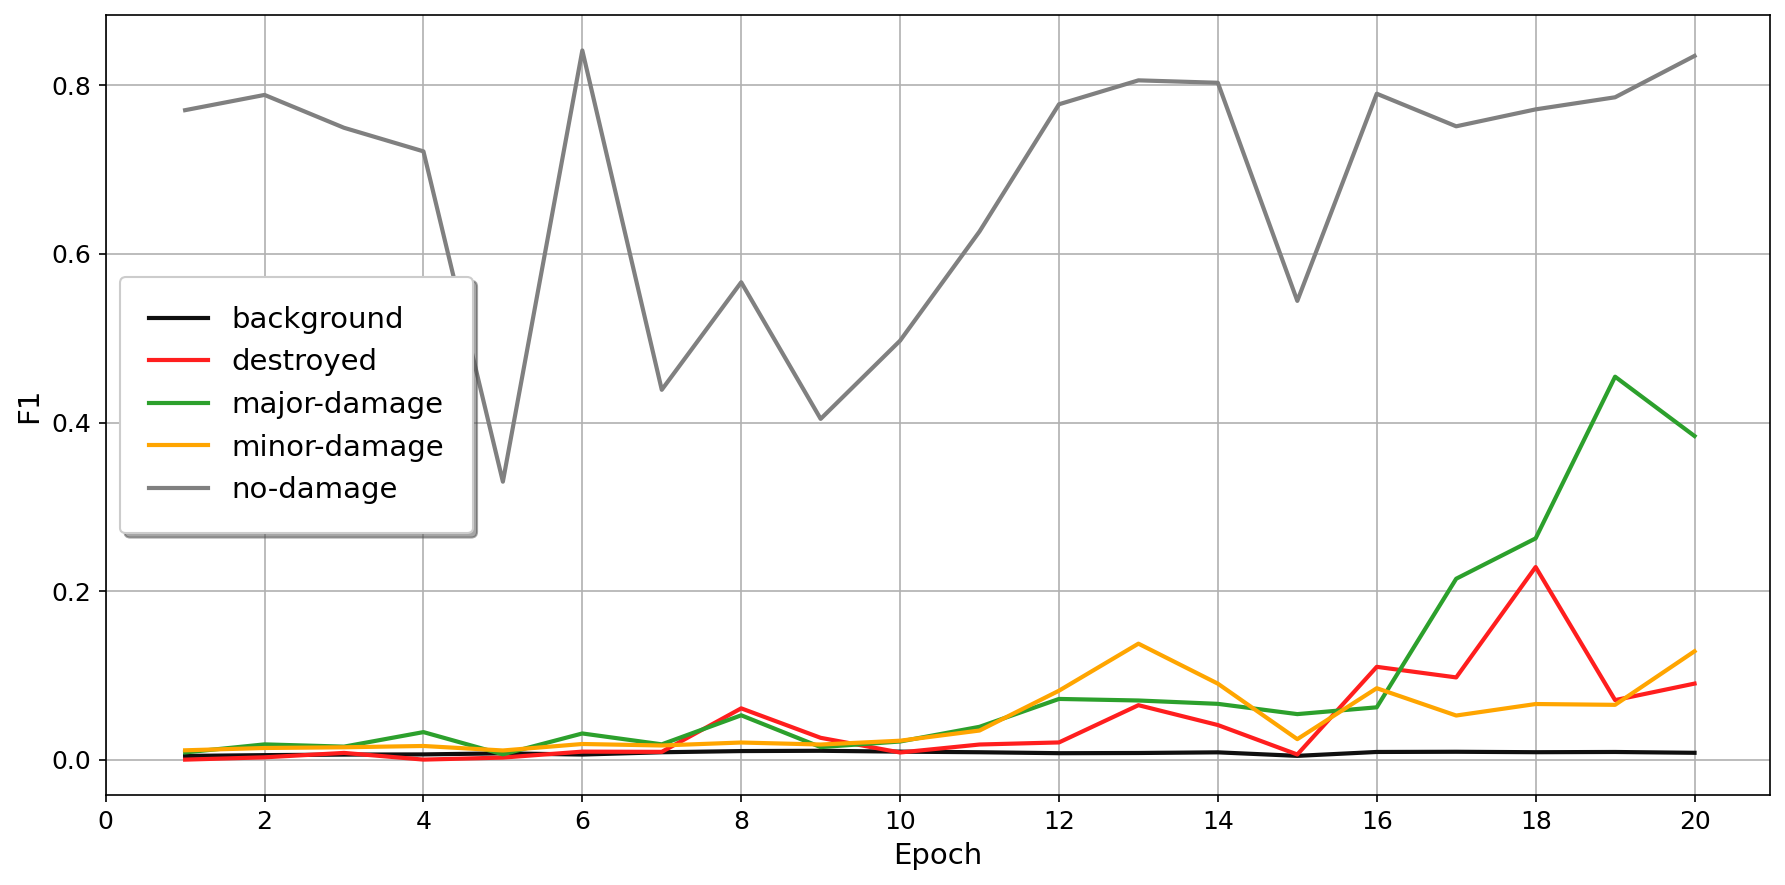

In [21]:
#val_f1_plots
from utils.visualization.label_to_color import LabelDict

dmg_val_df = pd.read_csv(def_metric_dir.join("val_dmg_pixel_level.csv"))

plot_metric_per_class(dmg_val_df, "f1",2)


In [22]:
dmg_val_df[dmg_val_df["epoch"] == 20]

,epoch,f1_harmonic_mean,class,precision,recall,f1,accuracy
95,20,0.034281,background,0.004097,0.428052,0.008117,0.552171
96,20,0.034281,no-damage,0.998645,0.717516,0.835054,0.919584
97,20,0.034281,minor-damage,0.068839,0.976376,0.128610,0.971550
98,20,0.034281,major-damage,0.240814,0.947222,0.384002,0.998094
99,20,0.034281,destroyed,0.057355,0.211570,0.090245,0.999821


### test metrics

In [23]:
bld_df = pd.read_csv(def_metric_dir.join("test_bld_pixel_level.csv"))
bld_df = bld_df.set_index(["epoch","class"])
dmg_df = pd.read_csv(def_metric_dir.join("test_dmg_pixel_level.csv"))
dmg_df = dmg_df.set_index(["epoch","class"])
loss_df = pd.read_csv(def_metric_dir.join("test_loss.csv"))
loss_df = loss_df.set_index(["epoch"])

In [24]:
best_f1_hm = dmg_df["f1_harmonic_mean"].max()
test_loss = loss_df.iloc[0].iloc[0]
seg_f1 = bld_df["f1"].iloc[0]

In [25]:
print(best_epoch, best_f1_hm, test_loss, seg_f1)

18 0.0078134077383935 0.1015446532292221 0.9864505862790433


# Experimento 2

In [26]:
path = FilePath("/home/mrtc101/Desktop/tesina/repo/prev_outs/exps/exp2_not_aug/out")


In [27]:
wei_df = build_weights_table(path)
wei_df

,Class,Weight
0,destroyed,15011
1,major-damage,850
2,minor-damage,223
3,no-damage,1


In [28]:
#pd.DataFrame.to_latex(index=False)
print(wei_df.to_latex(index=False))

\begin{tabular}{lr}
\toprule
Class & Weight \\
\midrule
destroyed & 15011 \\
major-damage & 850 \\
minor-damage & 223 \\
no-damage & 1 \\
\bottomrule
\end{tabular}



In [29]:
params_df = build_conf_table(path)
params_df

,Number,Batch size,Learning rate,Total epochs
0,Config 0,16,0.0010,100
1,Config 1,16,0.0001,100
2,Config 2,32,0.0010,100
3,Config 3,32,0.0001,100
4,Config 4,64,0.0010,100
5,Config 5,64,0.0001,100


In [30]:
print(params_df.to_latex(index=False))

\begin{tabular}{lrrr}
\toprule
Number & Batch size & Learning rate & Total epochs \\
\midrule
Config 0 & 16 & 0.001000 & 100 \\
Config 1 & 16 & 0.000100 & 100 \\
Config 2 & 32 & 0.001000 & 100 \\
Config 3 & 32 & 0.000100 & 100 \\
Config 4 & 64 & 0.001000 & 100 \\
Config 5 & 64 & 0.000100 & 100 \\
\bottomrule
\end{tabular}



In [31]:
fold_df = build_fold_table(path)
fold_df = fold_df.sort_values(by=["Conf","Fold"])
fold_df = fold_df.groupby('Conf').apply(lambda x: x.set_index('Fold'), include_groups=False)
fold_df

Best epoch  Harmonic-mean-f1  val-loss    Seg-f1
Conf Fold                                                  
C0   F0            72          0.031585  0.105326  0.993486
     F1            90          0.035972  0.102935  0.992221
     F2            90          0.026105  0.103624  0.988901
     F3            11          0.012479  0.116164  0.996222
     F4            98          0.030961  0.106015  0.987273
C1   F0            56          0.022411  0.093907  0.979568
     F1            82          0.034655  0.096168  0.979431
     F2            58          0.017901  0.098297  0.971014
     F3            31          0.038864  0.099148  0.993516
     F4            61          0.034222  0.099905  0.969588
C2   F0            96          0.035328  0.051354  0.981883
     F1            98          0.018610  0.052029  0.989156
     F2            95          0.013469  0.055902  0.990720
     F3            66          0.023902  0.055984  0.989357
     F4            77          0.025914  0.056856  0.976414
C3   F0            16          0.020485  0.056597  0.986226
     F1            83          0.023658  0.047934  0.951872
     F2            22          0.038555  0.060889  0.979985
     F3            56          0.025665  0.050768  0.974740
     F4            57          0.017917  0.048243  0.980678
C4   F0            94          0.022690  0.025629  0.987851
     F1            28          0.017604  0.029575  0.982524
     F2            78          0.025814  0.026964  0.979607
     F3            81          0.018909  0.026489  0.985029
     F4            49          0.009587  0.029371  0.990029
C5   F0            94          0.037101  0.023141  0.960797
     F1            66          0.026482  0.024989  0.928957
     F2            11          0.015692  0.034443  0.950482
     F3            45          0.028472  0.025886  0.983995
     F4            61          0.031594  0.025213  0.962746

In [32]:
fold_df["Harmonic-mean-f1"].idxmax()

('C1', 'F3')

In [33]:
print(fold_df.to_latex())

\begin{tabular}{llrrrr}
\toprule
 &  & Best epoch & Harmonic-mean-f1 & val-loss & Seg-f1 \\
Conf & Fold &  &  &  &  \\
\midrule
\multirow[t]{5}{*}{C0} & F0 & 72 & 0.031585 & 0.105326 & 0.993486 \\
 & F1 & 90 & 0.035972 & 0.102935 & 0.992221 \\
 & F2 & 90 & 0.026105 & 0.103624 & 0.988901 \\
 & F3 & 11 & 0.012479 & 0.116164 & 0.996222 \\
 & F4 & 98 & 0.030961 & 0.106015 & 0.987273 \\
\cline{1-6}
\multirow[t]{5}{*}{C1} & F0 & 56 & 0.022411 & 0.093907 & 0.979568 \\
 & F1 & 82 & 0.034655 & 0.096168 & 0.979431 \\
 & F2 & 58 & 0.017901 & 0.098297 & 0.971014 \\
 & F3 & 31 & 0.038864 & 0.099148 & 0.993516 \\
 & F4 & 61 & 0.034222 & 0.099905 & 0.969588 \\
\cline{1-6}
\multirow[t]{5}{*}{C2} & F0 & 96 & 0.035328 & 0.051354 & 0.981883 \\
 & F1 & 98 & 0.018610 & 0.052029 & 0.989156 \\
 & F2 & 95 & 0.013469 & 0.055902 & 0.990720 \\
 & F3 & 66 & 0.023902 & 0.055984 & 0.989357 \\
 & F4 & 77 & 0.025914 & 0.056856 & 0.976414 \\
\cline{1-6}
\multirow[t]{5}{*}{C3} & F0 & 16 & 0.020485 & 0.056597 & 0.986226

### validation metrics

In [34]:
def_metric_dir = path.join("definitive_model/metrics/csv")
def_metric_dir

'/home/mrtc101/Desktop/tesina/repo/prev_outs/exps/exp2_not_aug/out/definitive_model/metrics/csv'

In [35]:
bld_df, dmg_df, loss_df = load_dfs(def_metric_dir)
best_f1_hm = dmg_df["f1_harmonic_mean"].max()
best_epoch = dmg_df["f1_harmonic_mean"].idxmax()[0]
val_loss = loss_df.loc[best_epoch].iloc[0]
seg_f1 = bld_df.loc[best_epoch,"f1"].iloc[0]
print(best_epoch, best_f1_hm, val_loss, seg_f1)

98 0.046884753818244 0.0931537149156406 0.996467577106522


In [36]:
loss_df.loc[[best_epoch]]

,loss
epoch,
98,0.093154


In [37]:
print(loss_df.loc[[best_epoch]].to_latex())

\begin{tabular}{lr}
\toprule
 & loss \\
epoch &  \\
\midrule
98 & 0.093154 \\
\bottomrule
\end{tabular}



In [38]:
bld_df.loc[best_epoch]

,f1_harmonic_mean,precision,recall,f1,accuracy
class,,,,,
1,0.996468,1.0,0.99296,0.996468,0.997569


In [39]:
print(bld_df.loc[best_epoch].to_latex())

\begin{tabular}{lrrrrr}
\toprule
 & f1_harmonic_mean & precision & recall & f1 & accuracy \\
class &  &  &  &  &  \\
\midrule
1 & 0.996468 & 1.000000 & 0.992960 & 0.996468 & 0.997569 \\
\bottomrule
\end{tabular}



In [40]:
dmg_df.loc[best_epoch]

,f1_harmonic_mean,precision,recall,f1,accuracy
class,,,,,
0,0.046885,0.005028,0.580883,0.009970,0.497423
1,0.046885,0.999171,0.790711,0.882802,0.941812
2,0.046885,0.264741,0.988815,0.417660,0.994108
3,0.046885,0.434652,0.985528,0.603250,0.999202
4,0.046885,0.787494,0.962336,0.866180,0.999988


In [41]:
print(dmg_df.loc[best_epoch].to_latex())

\begin{tabular}{lrrrrr}
\toprule
 & f1_harmonic_mean & precision & recall & f1 & accuracy \\
class &  &  &  &  &  \\
\midrule
0 & 0.046885 & 0.005028 & 0.580883 & 0.009970 & 0.497423 \\
1 & 0.046885 & 0.999171 & 0.790711 & 0.882802 & 0.941812 \\
2 & 0.046885 & 0.264741 & 0.988815 & 0.417660 & 0.994108 \\
3 & 0.046885 & 0.434652 & 0.985528 & 0.603250 & 0.999202 \\
4 & 0.046885 & 0.787494 & 0.962336 & 0.866180 & 0.999988 \\
\bottomrule
\end{tabular}



In [42]:
dmg_res_df = dmg_df.loc[[best_epoch]].reset_index()
dmg_res_df["class"] = dmg_res_df["class"].apply(LabelDict().get_key_by_num)
dmg_res_df = dmg_res_df.drop(columns=["epoch"])
bld_res_df = bld_df.loc[[best_epoch]].reset_index()
bld_res_df = bld_res_df.drop(columns=["epoch"])
bld_res_df["class"] = "is-building"
res_df = pd.concat([bld_res_df, dmg_res_df])
print("\multicolumn{2}{l}{Configuración "+f"{'?'}"+"} & \multicolumn{2}{l}{Mejor época "+f"{best_epoch}"+"} & \multicolumn{2}{r}{\emph{loss} = "+f"{val_loss}"+"} \\")
print(res_df.to_latex(index=False))

\multicolumn{2}{l}{Configuración ?} & \multicolumn{2}{l}{Mejor época 98} & \multicolumn{2}{r}{\emph{loss} = 0.0931537149156406} \
\begin{tabular}{lrrrrr}
\toprule
class & f1_harmonic_mean & precision & recall & f1 & accuracy \\
\midrule
is-building & 0.996468 & 1.000000 & 0.992960 & 0.996468 & 0.997569 \\
background & 0.046885 & 0.005028 & 0.580883 & 0.009970 & 0.497423 \\
no-damage & 0.046885 & 0.999171 & 0.790711 & 0.882802 & 0.941812 \\
minor-damage & 0.046885 & 0.264741 & 0.988815 & 0.417660 & 0.994108 \\
major-damage & 0.046885 & 0.434652 & 0.985528 & 0.603250 & 0.999202 \\
destroyed & 0.046885 & 0.787494 & 0.962336 & 0.866180 & 0.999988 \\
\bottomrule
\end{tabular}



# Plot metrics over validation

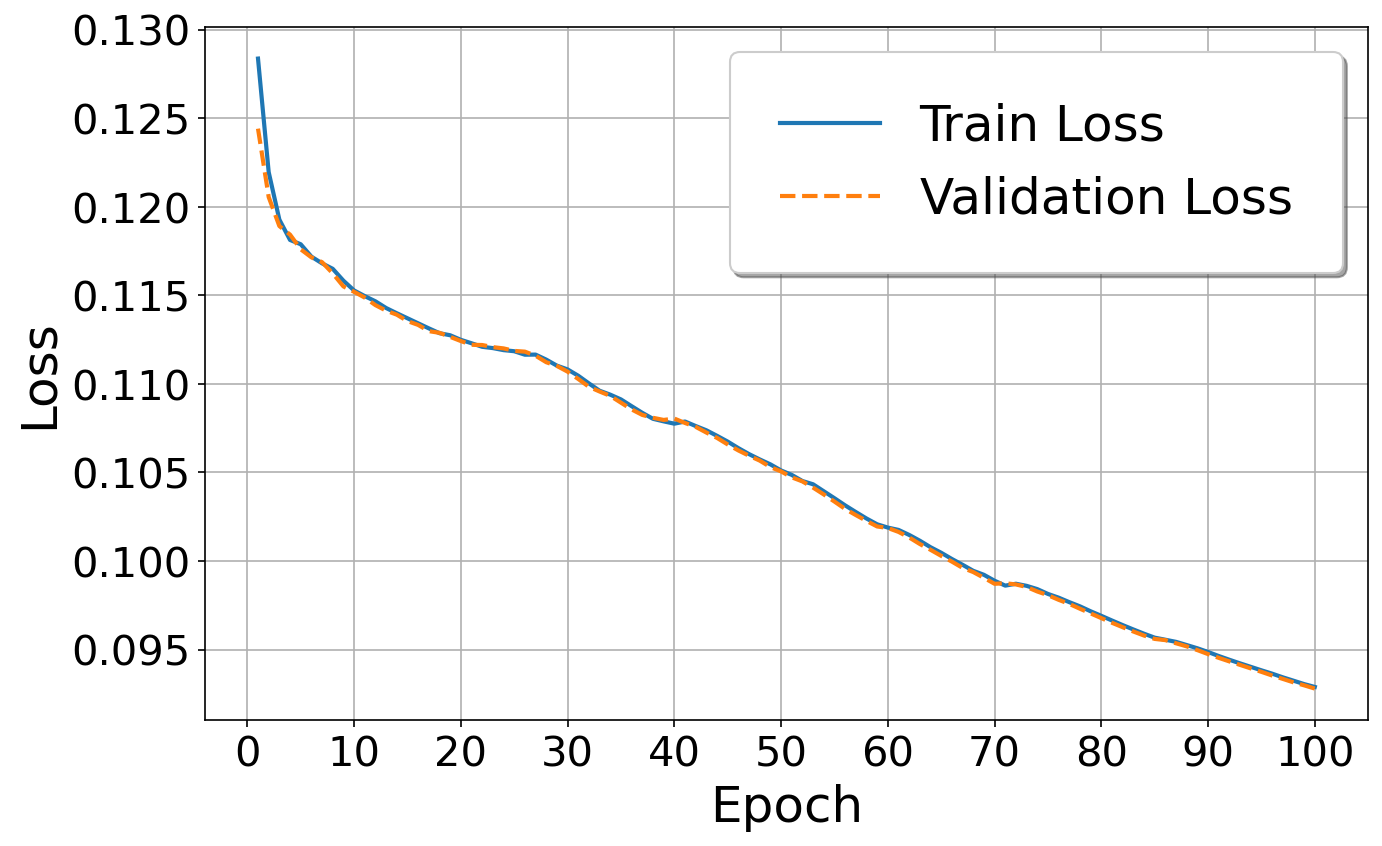

In [43]:

#loss_plots
loss_train_df = pd.read_csv(def_metric_dir.join("train_loss.csv"))
loss_train_df = loss_train_df.set_index("epoch")

loss_val_df = pd.read_csv(def_metric_dir.join("val_loss.csv"))
loss_val_df = loss_val_df.set_index("epoch")

plot_loss(loss_train_df, loss_val_df,10)


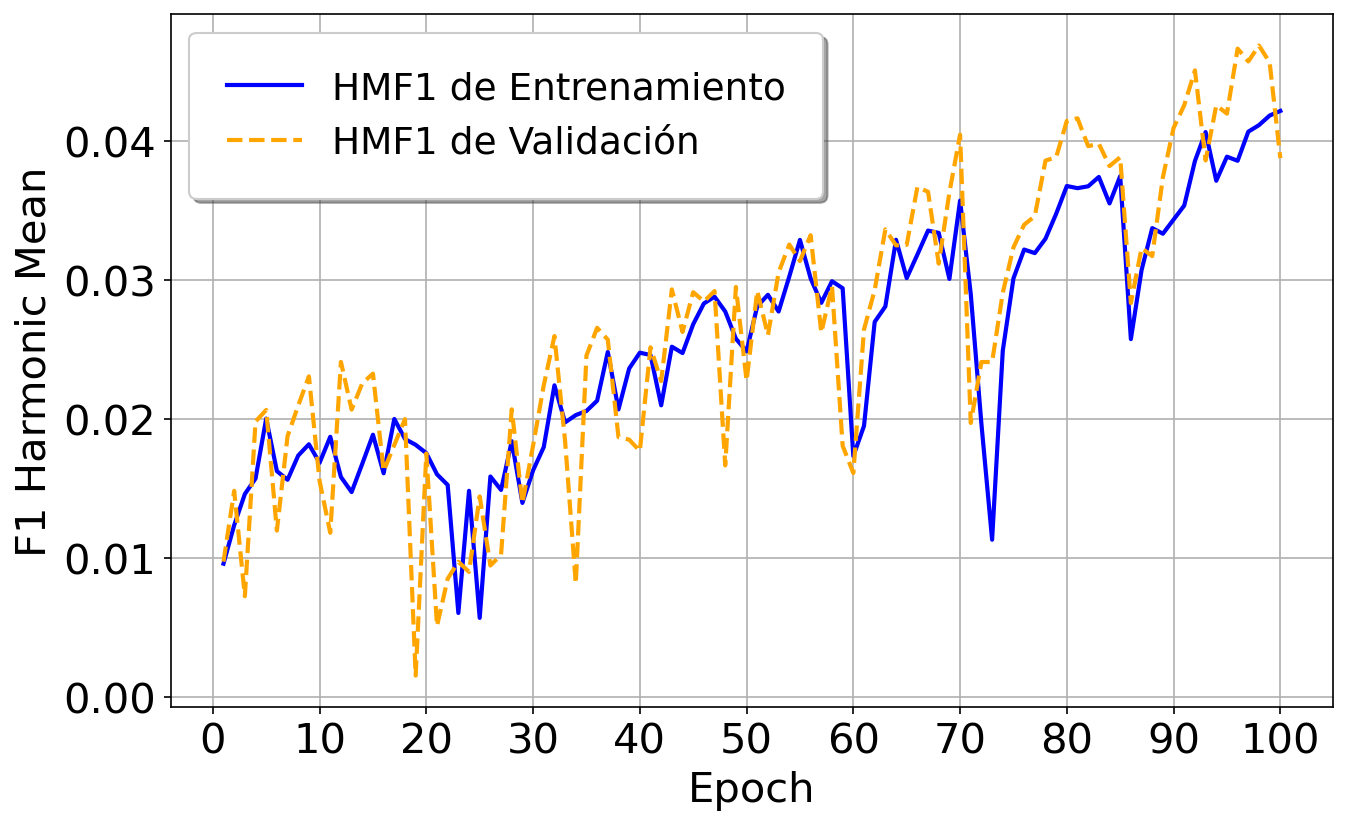

In [44]:
dmg_train_df = pd.read_csv(def_metric_dir.join("train_dmg_pixel_level.csv"))
dmg_val_df = pd.read_csv(def_metric_dir.join("val_dmg_pixel_level.csv"))

plot_harmonic_mean(dmg_train_df, dmg_val_df,10)

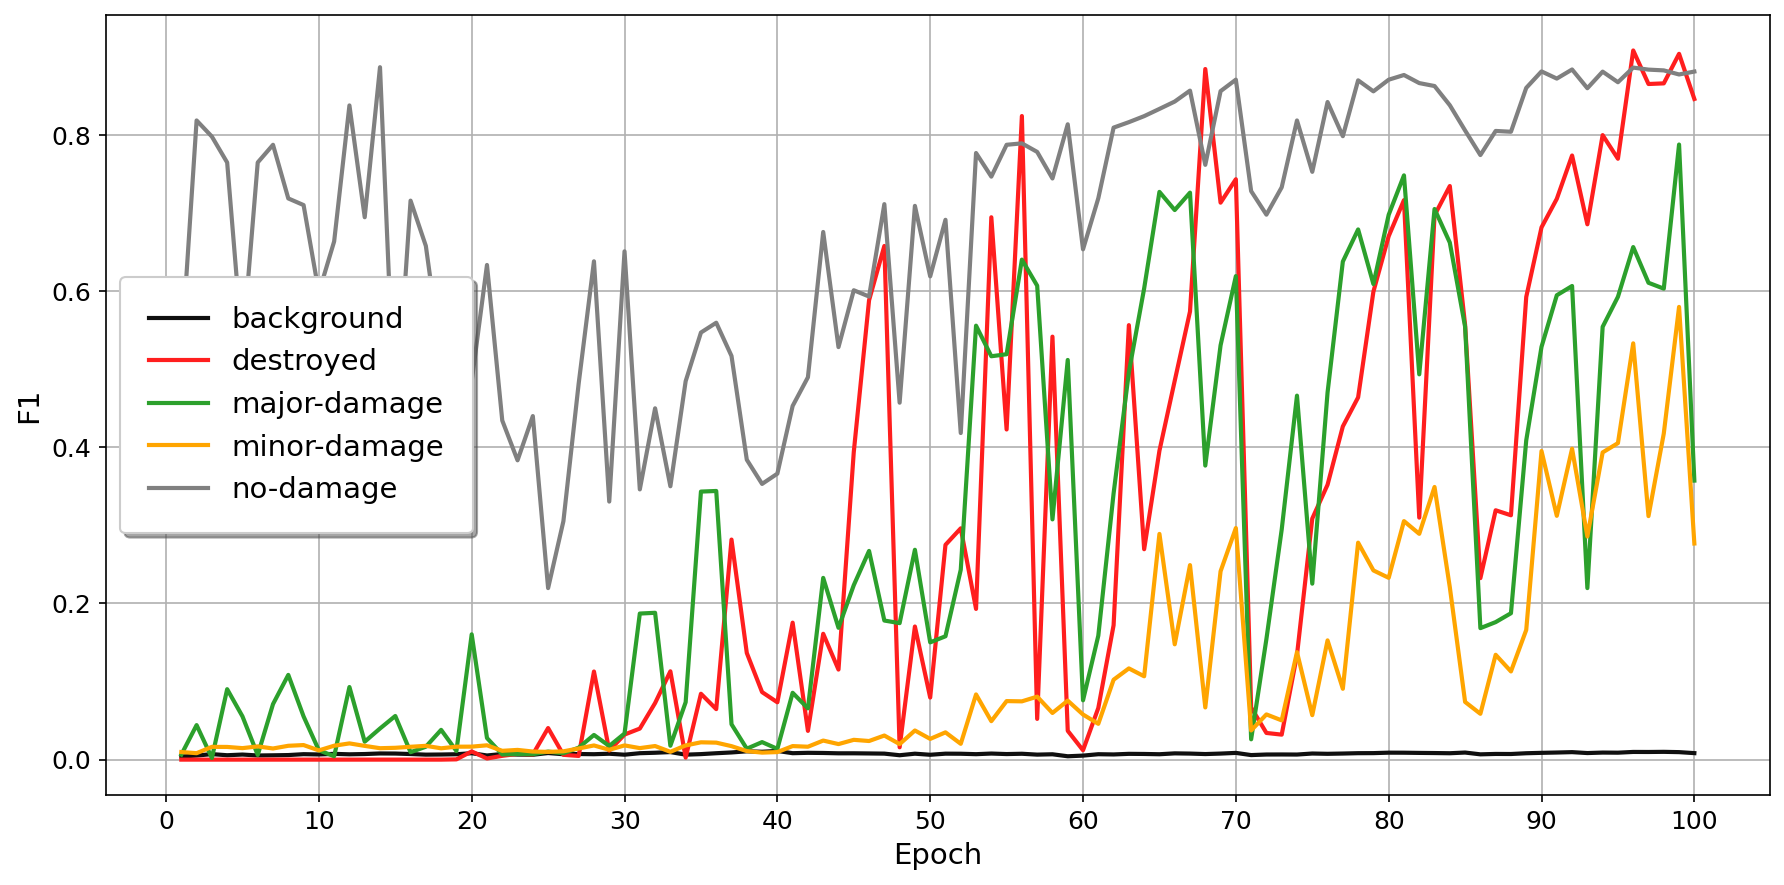

In [45]:
#val_f1_plots
from utils.visualization.label_to_color import LabelDict

dmg_val_df = pd.read_csv(def_metric_dir.join("val_dmg_pixel_level.csv"))

plot_metric_per_class(dmg_val_df, "f1",10)


In [46]:
dmg_val_df

,epoch,f1_harmonic_mean,class,precision,recall,f1,accuracy
0,1,0.009758,background,0.001995,0.665979,0.003978,0.214401
1,1,0.009758,no-damage,0.992607,0.352348,0.520081,0.822915
2,1,0.009758,minor-damage,0.005157,0.084020,0.009717,0.964127
3,1,0.009758,major-damage,0.004941,0.009098,0.006404,0.998264
4,1,0.009758,destroyed,0.000000,0.000000,0.000000,0.999958
...,...,...,...,...,...,...,...
495,100,0.038786,background,0.004199,0.447021,0.008321,0.564882
496,100,0.038786,no-damage,0.998711,0.788598,0.881304,0.940711
497,100,0.038786,minor-damage,0.161853,0.955507,0.276816,0.989358
498,100,0.038786,major-damage,0.217954,0.991964,0.357384,0.997802


### test metrics

In [47]:
test_metric_dir = path.join("definitive_model/best_metrics/csv")
bld_df = pd.read_csv(test_metric_dir.join("test_bld_pixel_level.csv"))
bld_df = bld_df.set_index(["epoch","class"])
bld_df

,,f1_harmonic_mean,precision,recall,f1,accuracy
epoch,class,,,,,
1,1,0.989479,1.0,0.979176,0.989479,0.990219


In [48]:
dmg_df = pd.read_csv(test_metric_dir.join("test_dmg_pixel_level.csv"))
dmg_df = dmg_df.set_index(["epoch","class"])
dmg_df

f1_harmonic_mean  precision    recall        f1  accuracy
epoch class                                                           
1     0              0.069172   0.007112  0.590528  0.014055  0.517801
      1              0.069172   0.994968  0.788681  0.879896  0.923053
      2              0.069172   0.000000  0.000000  0.000000  0.991943
      3              0.069172   0.000000  0.000000  0.000000  0.998843
      4              0.069172   0.000000  0.000000  0.000000  0.999999

In [49]:
loss_df = pd.read_csv(test_metric_dir.join("test_loss.csv"))
loss_df = loss_df.set_index(["epoch"])
loss_df

,loss
epoch,
1,0.138403


In [50]:
best_f1_hm = dmg_df["f1_harmonic_mean"].max()
test_loss = loss_df.iloc[0].iloc[0]
seg_f1 = bld_df["f1"].iloc[0]
print(best_epoch, best_f1_hm, test_loss, seg_f1)

98 0.0691717846772273 0.1384032027795911 0.9894785634716656


In [51]:
dmg_res_df = dmg_df.reset_index()
dmg_res_df["class"] = dmg_res_df["class"].apply(LabelDict().get_key_by_num)
dmg_res_df = dmg_res_df.drop(columns=["epoch"])
bld_res_df = bld_df.reset_index()
bld_res_df = bld_res_df.drop(columns=["epoch"])
bld_res_df["class"] = "is-building"
res_df = pd.concat([bld_res_df, dmg_res_df])
print("\multicolumn{2}{l}{Configuración "+f"{'?'}"+"} & \multicolumn{2}{l}{Mejor época "+f"{best_epoch}"+"} & \multicolumn{2}{r}{\emph{loss} = "+f"{val_loss}"+"} \\")
print(res_df.to_latex(index=False))

\multicolumn{2}{l}{Configuración ?} & \multicolumn{2}{l}{Mejor época 98} & \multicolumn{2}{r}{\emph{loss} = 0.0931537149156406} \
\begin{tabular}{lrrrrr}
\toprule
class & f1_harmonic_mean & precision & recall & f1 & accuracy \\
\midrule
is-building & 0.989479 & 1.000000 & 0.979176 & 0.989479 & 0.990219 \\
background & 0.069172 & 0.007112 & 0.590528 & 0.014055 & 0.517801 \\
no-damage & 0.069172 & 0.994968 & 0.788681 & 0.879896 & 0.923053 \\
minor-damage & 0.069172 & 0.000000 & 0.000000 & 0.000000 & 0.991943 \\
major-damage & 0.069172 & 0.000000 & 0.000000 & 0.000000 & 0.998843 \\
destroyed & 0.069172 & 0.000000 & 0.000000 & 0.000000 & 0.999999 \\
\bottomrule
\end{tabular}



# Experimento 3

In [52]:
path = FilePath("/home/mrtc101/Desktop/tesina/repo/prev_outs/exps/exp3_aug/out")

In [53]:
wei_df = build_weights_table(path)
wei_df

,Class,Weight
0,destroyed,5
1,major-damage,5
2,minor-damage,5
3,no-damage,2


In [54]:
#pd.DataFrame.to_latex(index=False)
print(wei_df.to_latex(index=False))

\begin{tabular}{lr}
\toprule
Class & Weight \\
\midrule
destroyed & 5 \\
major-damage & 5 \\
minor-damage & 5 \\
no-damage & 2 \\
\bottomrule
\end{tabular}



In [55]:
params_df = build_conf_table(path)
params_df

,Number,Batch size,Learning rate,Total epochs
0,Config 0,16,0.0010,100
1,Config 1,16,0.0001,100
2,Config 2,32,0.0010,100
3,Config 3,32,0.0001,100
4,Config 4,64,0.0010,100
5,Config 5,64,0.0001,100


In [56]:
print(params_df.to_latex(index=False))

\begin{tabular}{lrrr}
\toprule
Number & Batch size & Learning rate & Total epochs \\
\midrule
Config 0 & 16 & 0.001000 & 100 \\
Config 1 & 16 & 0.000100 & 100 \\
Config 2 & 32 & 0.001000 & 100 \\
Config 3 & 32 & 0.000100 & 100 \\
Config 4 & 64 & 0.001000 & 100 \\
Config 5 & 64 & 0.000100 & 100 \\
\bottomrule
\end{tabular}



In [57]:
fold_df = build_fold_table(path)
fold_df = fold_df.sort_values(by=["Conf","Fold"])
fold_df = fold_df.groupby('Conf').apply(lambda x: x.set_index('Fold'), include_groups=False)
fold_df

Best epoch  Harmonic-mean-f1  val-loss    Seg-f1
Conf Fold                                                  
C0   F0            42          0.011104  0.072671  0.993726
     F1            42          0.008038  0.077324  0.991399
     F2            35          0.033104  0.075749  0.992795
     F3            37          0.010266  0.076193  0.991662
     F4            35          0.008179  0.071742  0.993177
C1   F0            69          0.013999  0.071948  0.990193
     F1            30          0.014800  0.073509  0.990487
     F2            35          0.021341  0.073826  0.993295
     F3             9          0.020421  0.083593  0.992102
     F4            30          0.011427  0.074895  0.990746
C2   F0            52          0.022171  0.037342  0.988854
     F1            24          0.007304  0.038872  0.994399
     F2            24          0.011948  0.039188  0.994413
     F3            20          0.015661  0.039789  0.990463
     F4            34          0.003661  0.038583  0.993402
C3   F0            74          0.007473  0.037767  0.989171
     F1             2          0.015425  0.058219  0.976479
     F2            21          0.013616  0.039193  0.992109
     F3            66          0.017979  0.037426  0.983112
     F4            48          0.014996  0.038067  0.991609
C4   F0            39          0.013558  0.019251  0.986067
     F1             3          0.018123  0.022813  0.995420
     F2            44          0.006065  0.020165  0.986194
     F3            24          0.006184  0.019591  0.993494
     F4             2          0.015298  0.024463  0.985940
C5   F0            32          0.013207  0.020023  0.989246
     F1            91          0.007061  0.018733  0.982822
     F2             3          0.004881  0.030247  0.937484
     F3            36          0.014230  0.019549  0.980227
     F4            35          0.007476  0.019372  0.991100

In [58]:
fold_df.idxmax()

Best epoch          (C5, F1)
Harmonic-mean-f1    (C0, F2)
val-loss            (C1, F3)
Seg-f1              (C4, F1)
dtype: object

In [59]:
print(fold_df.to_latex())

\begin{tabular}{llrrrr}
\toprule
 &  & Best epoch & Harmonic-mean-f1 & val-loss & Seg-f1 \\
Conf & Fold &  &  &  &  \\
\midrule
\multirow[t]{5}{*}{C0} & F0 & 42 & 0.011104 & 0.072671 & 0.993726 \\
 & F1 & 42 & 0.008038 & 0.077324 & 0.991399 \\
 & F2 & 35 & 0.033104 & 0.075749 & 0.992795 \\
 & F3 & 37 & 0.010266 & 0.076193 & 0.991662 \\
 & F4 & 35 & 0.008179 & 0.071742 & 0.993177 \\
\cline{1-6}
\multirow[t]{5}{*}{C1} & F0 & 69 & 0.013999 & 0.071948 & 0.990193 \\
 & F1 & 30 & 0.014800 & 0.073509 & 0.990487 \\
 & F2 & 35 & 0.021341 & 0.073826 & 0.993295 \\
 & F3 & 9 & 0.020421 & 0.083593 & 0.992102 \\
 & F4 & 30 & 0.011427 & 0.074895 & 0.990746 \\
\cline{1-6}
\multirow[t]{5}{*}{C2} & F0 & 52 & 0.022171 & 0.037342 & 0.988854 \\
 & F1 & 24 & 0.007304 & 0.038872 & 0.994399 \\
 & F2 & 24 & 0.011948 & 0.039188 & 0.994413 \\
 & F3 & 20 & 0.015661 & 0.039789 & 0.990463 \\
 & F4 & 34 & 0.003661 & 0.038583 & 0.993402 \\
\cline{1-6}
\multirow[t]{5}{*}{C3} & F0 & 74 & 0.007473 & 0.037767 & 0.989171 

### validation metrics

In [60]:
def_metric_dir = path.join("definitive_model/metrics/csv")
def_metric_dir

'/home/mrtc101/Desktop/tesina/repo/prev_outs/exps/exp3_aug/out/definitive_model/metrics/csv'

In [61]:
bld_df, dmg_df, loss_df = load_dfs(def_metric_dir)
best_f1_hm = dmg_df["f1_harmonic_mean"].max()
best_epoch = dmg_df["f1_harmonic_mean"].idxmax()[0]
val_loss = loss_df.loc[best_epoch].iloc[0]
seg_f1 = bld_df.loc[best_epoch,"f1"].iloc[0]
print(best_epoch, best_f1_hm, val_loss, seg_f1)

31 0.0194757526032138 0.0857139377771218 0.9976317595831732


In [62]:
loss_df.loc[[best_epoch]]

,loss
epoch,
31,0.085714


In [63]:
print(loss_df.loc[[best_epoch]].to_latex())

\begin{tabular}{lr}
\toprule
 & loss \\
epoch &  \\
\midrule
31 & 0.085714 \\
\bottomrule
\end{tabular}



In [64]:
bld_df.loc[best_epoch]

,f1_harmonic_mean,precision,recall,f1,accuracy
class,,,,,
1,0.997632,1.0,0.995275,0.997632,0.998171


In [65]:
print(bld_df.loc[best_epoch].to_latex())

\begin{tabular}{lrrrrr}
\toprule
 & f1_harmonic_mean & precision & recall & f1 & accuracy \\
class &  &  &  &  &  \\
\midrule
1 & 0.997632 & 1.000000 & 0.995275 & 0.997632 & 0.998171 \\
\bottomrule
\end{tabular}



In [66]:
dmg_df.loc[best_epoch]

,f1_harmonic_mean,precision,recall,f1,accuracy
class,,,,,
0,0.019476,0.001998,0.592648,0.003983,0.685154
1,0.019476,0.806186,0.848673,0.826884,0.927092
2,0.019476,0.841546,0.442466,0.579987,0.929846
3,0.019476,0.800448,0.648542,0.716532,0.969647
4,0.019476,0.698211,0.805041,0.747830,0.970852


In [67]:
print(dmg_df.loc[best_epoch].to_latex())

\begin{tabular}{lrrrrr}
\toprule
 & f1_harmonic_mean & precision & recall & f1 & accuracy \\
class &  &  &  &  &  \\
\midrule
0 & 0.019476 & 0.001998 & 0.592648 & 0.003983 & 0.685154 \\
1 & 0.019476 & 0.806186 & 0.848673 & 0.826884 & 0.927092 \\
2 & 0.019476 & 0.841546 & 0.442466 & 0.579987 & 0.929846 \\
3 & 0.019476 & 0.800448 & 0.648542 & 0.716532 & 0.969647 \\
4 & 0.019476 & 0.698211 & 0.805041 & 0.747830 & 0.970852 \\
\bottomrule
\end{tabular}



In [68]:
dmg_res_df = dmg_df.loc[[best_epoch]].reset_index()
dmg_res_df["class"] = dmg_res_df["class"].apply(LabelDict().get_key_by_num)
dmg_res_df = dmg_res_df.drop(columns=["epoch"])
bld_res_df = bld_df.loc[[best_epoch]].reset_index()
bld_res_df = bld_res_df.drop(columns=["epoch"])
bld_res_df["class"] = "is-building"
res_df = pd.concat([bld_res_df, dmg_res_df])
print("\multicolumn{2}{l}{Configuración "+f"{'?'}"+"} & \multicolumn{2}{l}{Mejor época "+f"{best_epoch}"+"} & \multicolumn{2}{r}{\emph{loss} = "+f"{val_loss}"+"} \\")
print(res_df.to_latex(index=False))

\multicolumn{2}{l}{Configuración ?} & \multicolumn{2}{l}{Mejor época 31} & \multicolumn{2}{r}{\emph{loss} = 0.0857139377771218} \
\begin{tabular}{lrrrrr}
\toprule
class & f1_harmonic_mean & precision & recall & f1 & accuracy \\
\midrule
is-building & 0.997632 & 1.000000 & 0.995275 & 0.997632 & 0.998171 \\
background & 0.019476 & 0.001998 & 0.592648 & 0.003983 & 0.685154 \\
no-damage & 0.019476 & 0.806186 & 0.848673 & 0.826884 & 0.927092 \\
minor-damage & 0.019476 & 0.841546 & 0.442466 & 0.579987 & 0.929846 \\
major-damage & 0.019476 & 0.800448 & 0.648542 & 0.716532 & 0.969647 \\
destroyed & 0.019476 & 0.698211 & 0.805041 & 0.747830 & 0.970852 \\
\bottomrule
\end{tabular}



# Plot metrics over validation

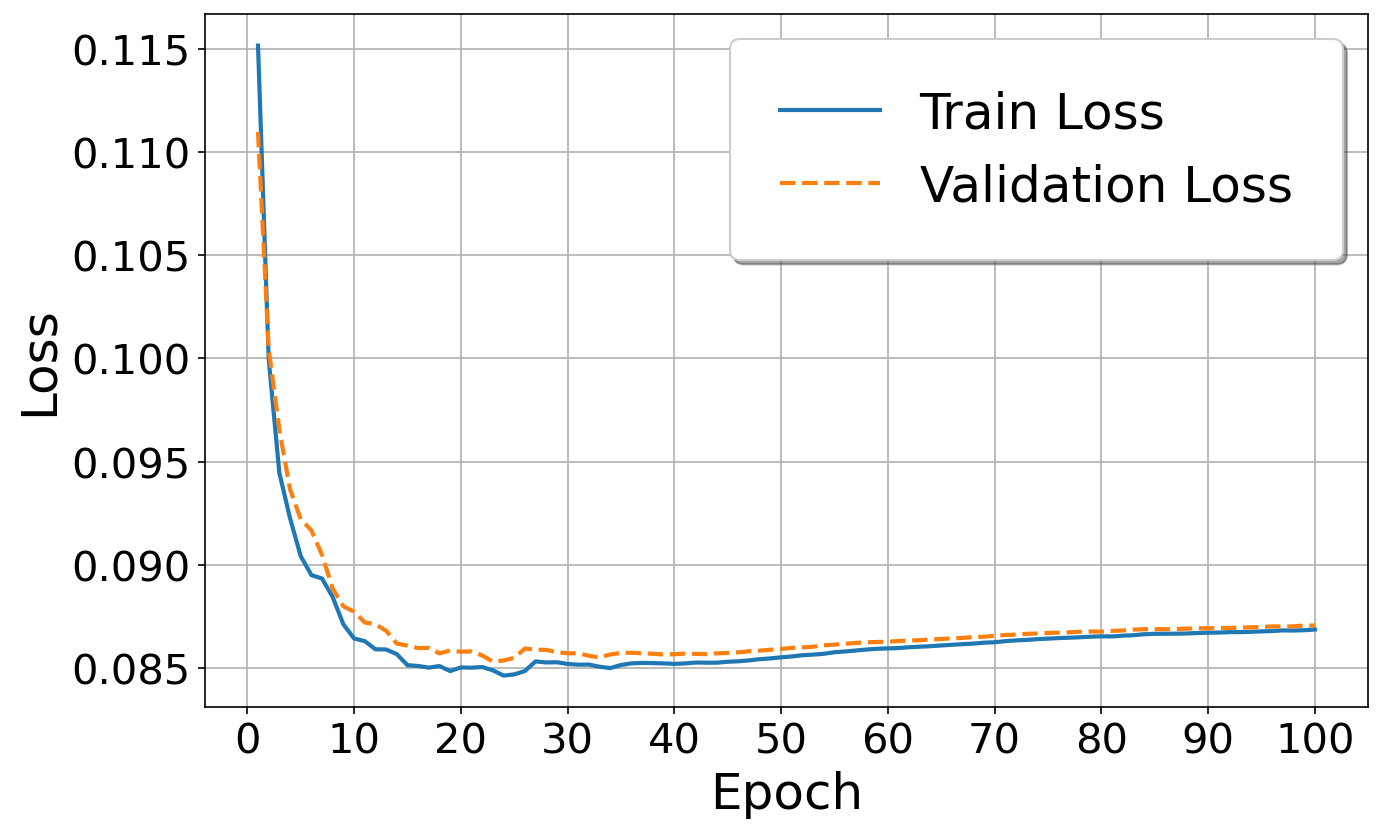

In [69]:

#loss_plots
loss_train_df = pd.read_csv(def_metric_dir.join("train_loss.csv"))
loss_train_df = loss_train_df.set_index("epoch")

loss_val_df = pd.read_csv(def_metric_dir.join("val_loss.csv"))
loss_val_df = loss_val_df.set_index("epoch")

plot_loss(loss_train_df, loss_val_df,10)


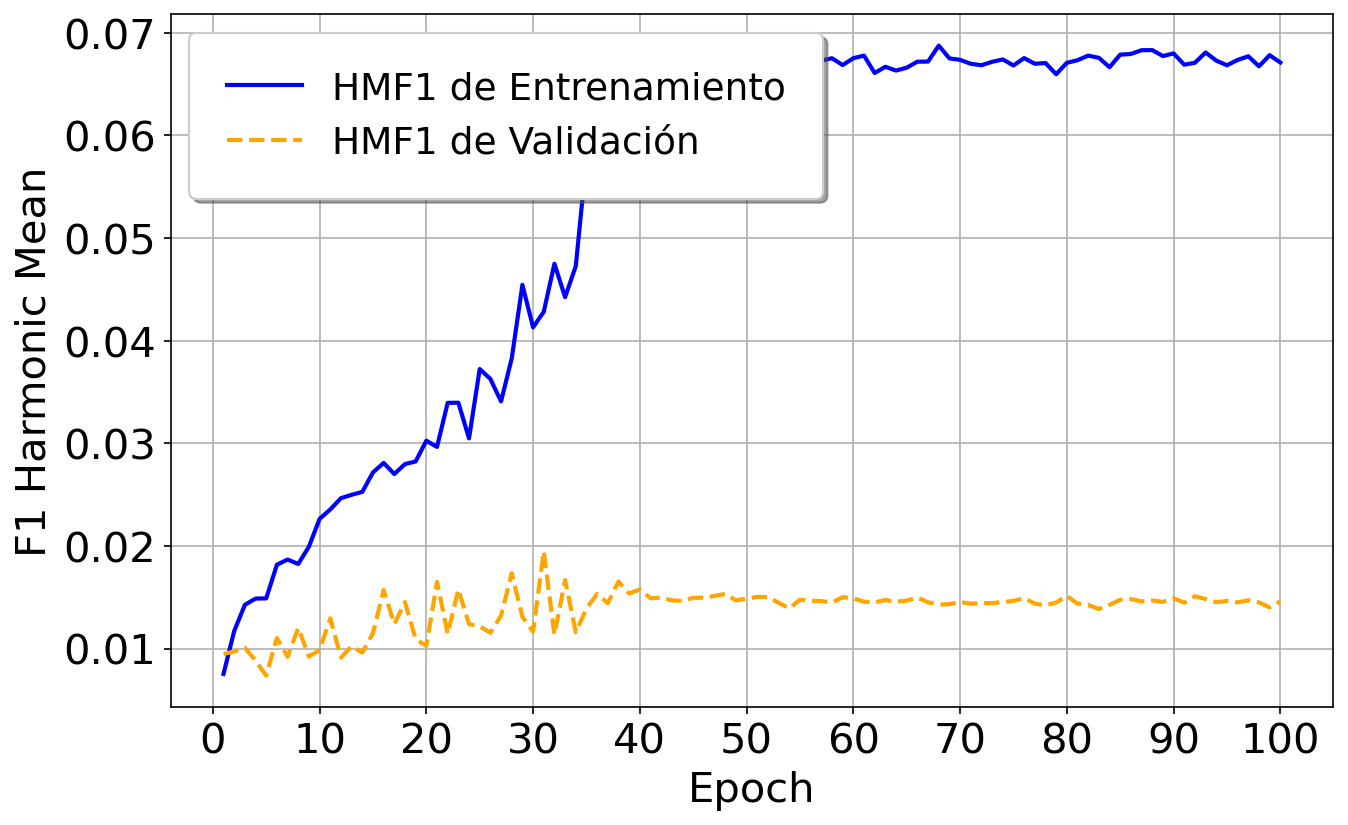

In [70]:
dmg_train_df = pd.read_csv(def_metric_dir.join("train_dmg_pixel_level.csv"))
dmg_val_df = pd.read_csv(def_metric_dir.join("val_dmg_pixel_level.csv"))

plot_harmonic_mean(dmg_train_df, dmg_val_df,10)

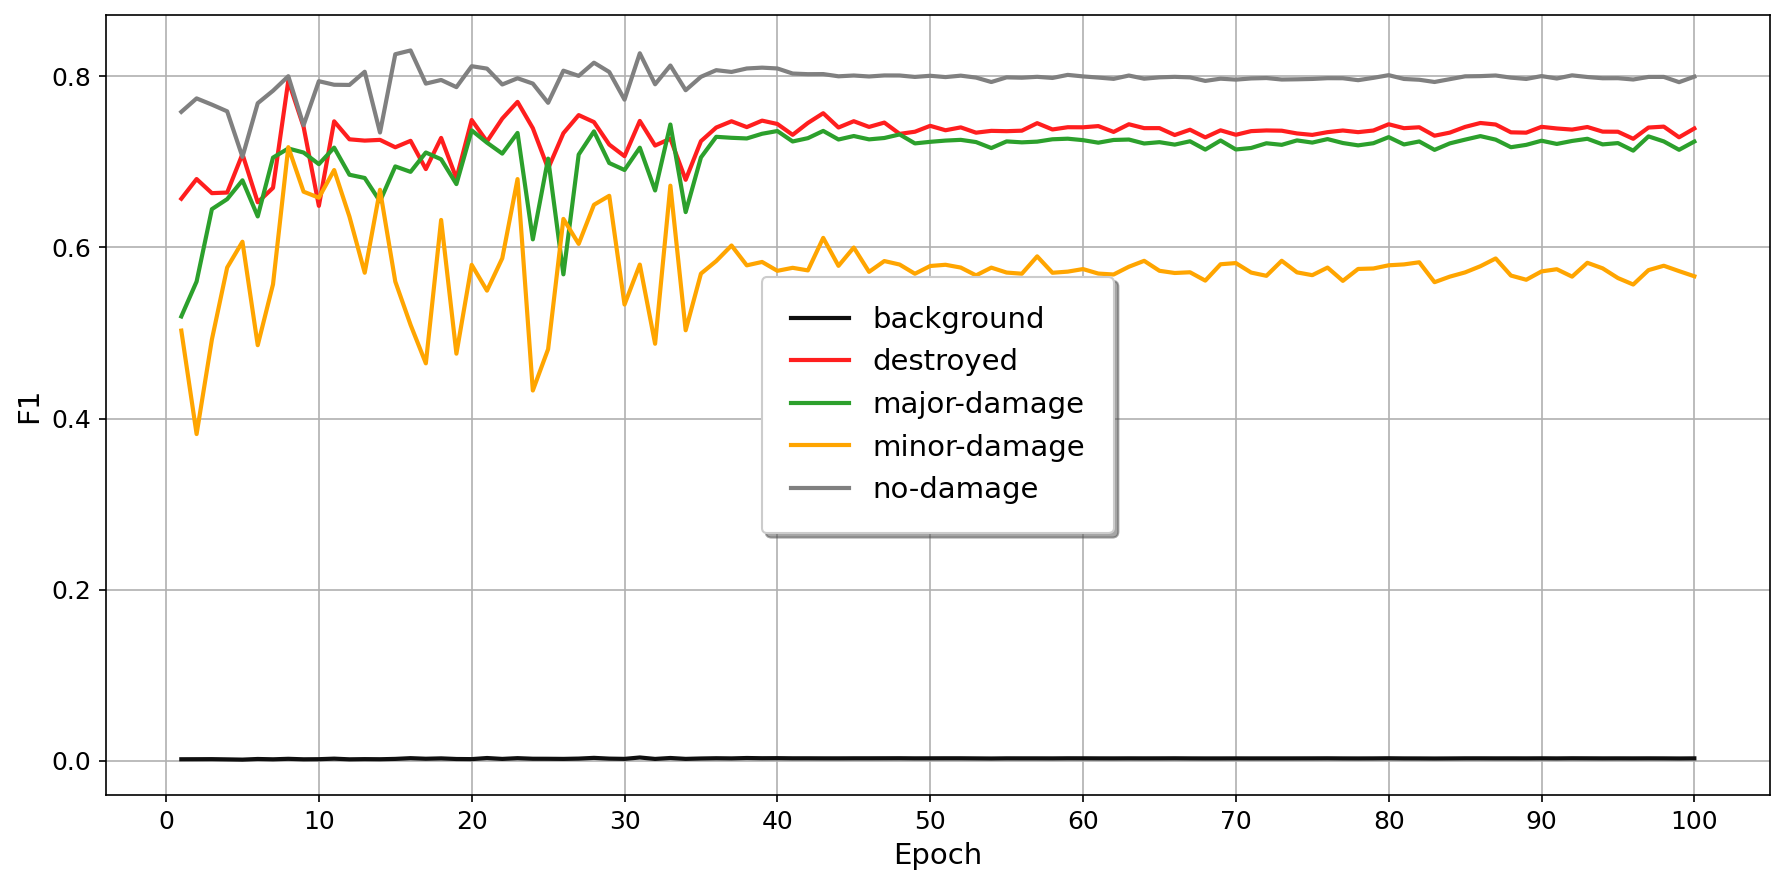

In [71]:
#val_f1_plots
from utils.visualization.label_to_color import LabelDict

dmg_val_df = pd.read_csv(def_metric_dir.join("val_dmg_pixel_level.csv"))

plot_metric_per_class(dmg_val_df, "f1",10)


### test metrics

In [72]:
test_metric_dir = path.join("definitive_model/best_metrics/csv")
bld_df = pd.read_csv(test_metric_dir.join("test_bld_pixel_level.csv"))
bld_df = bld_df.set_index(["epoch","class"])
bld_df

,,f1_harmonic_mean,precision,recall,f1,accuracy
epoch,class,,,,,
1,1,0.982463,1.0,0.965531,0.982463,0.988642


In [73]:
dmg_df = pd.read_csv(test_metric_dir.join("test_dmg_pixel_level.csv"))
dmg_df = dmg_df.set_index(["epoch","class"])
dmg_df

f1_harmonic_mean  precision    recall        f1  accuracy
epoch class                                                           
1     0              0.033979   0.003439  0.729083  0.006846  0.774842
      1              0.033979   0.992948  0.854302  0.918422  0.956403
      2              0.033979   0.000000  0.000000  0.000000  0.996978
      3              0.033979   0.000000  0.000000  0.000000  0.998874
      4              0.033979   0.000000  0.000000  0.000000  0.999157

In [74]:
loss_df = pd.read_csv(test_metric_dir.join("test_loss.csv"))
loss_df = loss_df.set_index(["epoch"])
loss_df

,loss
epoch,
1,0.115851


In [75]:
best_f1_hm = dmg_df["f1_harmonic_mean"].max()
test_loss = loss_df.iloc[0].iloc[0]
seg_f1 = bld_df["f1"].iloc[0]
print(best_epoch, best_f1_hm, test_loss, seg_f1)

31 0.0339788499884467 0.1158505700528621 0.9824631820325012


In [76]:
dmg_res_df = dmg_df.reset_index()
dmg_res_df["class"] = dmg_res_df["class"].apply(LabelDict().get_key_by_num)
dmg_res_df = dmg_res_df.drop(columns=["epoch"])
bld_res_df = bld_df.reset_index()
bld_res_df = bld_res_df.drop(columns=["epoch"])
bld_res_df["class"] = "is-building"
res_df = pd.concat([bld_res_df, dmg_res_df])
print("\multicolumn{2}{l}{Configuración "+f"{'?'}"+"} & \multicolumn{2}{l}{Mejor época "+f"{best_epoch}"+"} & \multicolumn{2}{r}{\emph{loss} = "+f"{val_loss}"+"} \\")
print(res_df.to_latex(index=False))

\multicolumn{2}{l}{Configuración ?} & \multicolumn{2}{l}{Mejor época 31} & \multicolumn{2}{r}{\emph{loss} = 0.0857139377771218} \
\begin{tabular}{lrrrrr}
\toprule
class & f1_harmonic_mean & precision & recall & f1 & accuracy \\
\midrule
is-building & 0.982463 & 1.000000 & 0.965531 & 0.982463 & 0.988642 \\
background & 0.033979 & 0.003439 & 0.729083 & 0.006846 & 0.774842 \\
no-damage & 0.033979 & 0.992948 & 0.854302 & 0.918422 & 0.956403 \\
minor-damage & 0.033979 & 0.000000 & 0.000000 & 0.000000 & 0.996978 \\
major-damage & 0.033979 & 0.000000 & 0.000000 & 0.000000 & 0.998874 \\
destroyed & 0.033979 & 0.000000 & 0.000000 & 0.000000 & 0.999157 \\
\bottomrule
\end{tabular}



# Experimento 4

In [77]:
path = FilePath("/home/mrtc101/Desktop/tesina/repo/prev_outs/exps/exp4_samp/out")

In [78]:
wei_df = build_weights_table(path)
wei_df

,Class,Weight
0,no-damage,7
1,minor-damage,15
2,major-damage,14
3,destroyed,14


In [79]:
#pd.DataFrame.to_latex(index=False)
print(wei_df.to_latex(index=False))

\begin{tabular}{lr}
\toprule
Class & Weight \\
\midrule
no-damage & 7 \\
minor-damage & 15 \\
major-damage & 14 \\
destroyed & 14 \\
\bottomrule
\end{tabular}



In [80]:
params_df = build_conf_table(path)
params_df

,Number,Batch size,Learning rate,Total epochs
0,Config 0,1,0.0010,50
1,Config 1,1,0.0001,50
2,Config 2,4,0.0010,50
3,Config 3,4,0.0001,50
4,Config 4,8,0.0010,50
5,Config 5,8,0.0001,50
6,Config 6,16,0.0010,50
7,Config 7,16,0.0001,50


In [81]:
print(params_df.to_latex(index=False))

\begin{tabular}{lrrr}
\toprule
Number & Batch size & Learning rate & Total epochs \\
\midrule
Config 0 & 1 & 0.001000 & 50 \\
Config 1 & 1 & 0.000100 & 50 \\
Config 2 & 4 & 0.001000 & 50 \\
Config 3 & 4 & 0.000100 & 50 \\
Config 4 & 8 & 0.001000 & 50 \\
Config 5 & 8 & 0.000100 & 50 \\
Config 6 & 16 & 0.001000 & 50 \\
Config 7 & 16 & 0.000100 & 50 \\
\bottomrule
\end{tabular}



In [82]:
fold_df = build_fold_table(path)
fold_df = fold_df.sort_values(by=["Conf","Fold"])
fold_df = fold_df.groupby('Conf').apply(lambda x: x.set_index('Fold'), include_groups=False)
fold_df

Best epoch  Harmonic-mean-f1  val-loss    Seg-f1
Conf Fold                                                  
C0   F0             1          0.189765  2.155280  0.726778
     F1             1          0.012045  2.174981  0.279847
     F2            31          0.084725  1.798154  0.576490
     F3             1          0.193964  2.160255  0.774051
C1   F0            33          0.124676  1.751260  0.760057
     F1            29          0.069707  1.843144  0.440483
     F2             3          0.117875  1.938381  0.736537
     F3            46          0.114420  1.747035  0.698960
C2   F0             1          0.271150  0.564896  0.890185
     F1            34          0.340343  0.453221  0.954186
     F2            26          0.346584  0.458485  0.919009
     F3             9          0.279725  0.483835  0.927705
     F4            16          0.243527  0.476644  0.892040
C3   F0            30          0.400099  0.419438  0.972955
     F1            17          0.516279  0.439399  0.981189
     F2            46          0.420703  0.406081  0.968588
     F3            49          0.426543  0.401852  0.958024
     F4             8          0.385530  0.465215  0.961418
C4   F0            30          0.319741  0.224340  0.927339
     F1            12          0.475820  0.234018  0.957844
     F2            19          0.485955  0.221417  0.971304
     F3            34          0.421136  0.212437  0.954948
     F4            26          0.457969  0.215504  0.981387
C5   F0            30          0.449753  0.206745  0.965919
     F1            18          0.468896  0.215478  0.977583
     F2            12          0.501617  0.225993  0.982955
     F3            33          0.471450  0.203695  0.981629
     F4            16          0.424506  0.217794  0.970444
C6   F0            26          0.484993  0.105426  0.989113
     F1            23          0.567198  0.106725  0.989175
     F2            35          0.565267  0.104383  0.991772
     F3            19          0.557886  0.109881  0.991912
     F4            12          0.420161  0.113375  0.992748
C7   F0            39          0.529605  0.098616  0.976847
     F1            30          0.375394  0.101537  0.980152
     F2             8          0.527760  0.118959  0.988730
     F3            19          0.515227  0.107297  0.978917
     F4            19          0.517629  0.109443  0.983317

In [83]:
fold_df.idxmax()

Best epoch          (C3, F3)
Harmonic-mean-f1    (C6, F1)
val-loss            (C0, F1)
Seg-f1              (C6, F4)
dtype: object

In [84]:
fold_df.idxmin()

Best epoch          (C0, F0)
Harmonic-mean-f1    (C0, F1)
val-loss            (C7, F0)
Seg-f1              (C0, F1)
dtype: object

In [85]:
print(fold_df.to_latex())

\begin{tabular}{llrrrr}
\toprule
 &  & Best epoch & Harmonic-mean-f1 & val-loss & Seg-f1 \\
Conf & Fold &  &  &  &  \\
\midrule
\multirow[t]{4}{*}{C0} & F0 & 1 & 0.189765 & 2.155280 & 0.726778 \\
 & F1 & 1 & 0.012045 & 2.174981 & 0.279847 \\
 & F2 & 31 & 0.084725 & 1.798154 & 0.576490 \\
 & F3 & 1 & 0.193964 & 2.160255 & 0.774051 \\
\cline{1-6}
\multirow[t]{4}{*}{C1} & F0 & 33 & 0.124676 & 1.751260 & 0.760057 \\
 & F1 & 29 & 0.069707 & 1.843144 & 0.440483 \\
 & F2 & 3 & 0.117875 & 1.938381 & 0.736537 \\
 & F3 & 46 & 0.114420 & 1.747035 & 0.698960 \\
\cline{1-6}
\multirow[t]{5}{*}{C2} & F0 & 1 & 0.271150 & 0.564896 & 0.890185 \\
 & F1 & 34 & 0.340343 & 0.453221 & 0.954186 \\
 & F2 & 26 & 0.346584 & 0.458485 & 0.919009 \\
 & F3 & 9 & 0.279725 & 0.483835 & 0.927705 \\
 & F4 & 16 & 0.243527 & 0.476644 & 0.892040 \\
\cline{1-6}
\multirow[t]{5}{*}{C3} & F0 & 30 & 0.400099 & 0.419438 & 0.972955 \\
 & F1 & 17 & 0.516279 & 0.439399 & 0.981189 \\
 & F2 & 46 & 0.420703 & 0.406081 & 0.968588 \\
 &

### validation metrics

In [86]:
def_metric_dir = path.join("definitive_model/metrics/csv")
def_metric_dir

'/home/mrtc101/Desktop/tesina/repo/prev_outs/exps/exp4_samp/out/definitive_model/metrics/csv'

In [87]:
bld_df, dmg_df, loss_df = load_dfs(def_metric_dir)
best_f1_hm = dmg_df["f1_harmonic_mean"].max()
best_epoch = dmg_df["f1_harmonic_mean"].idxmax()[0]
val_loss = loss_df.loc[best_epoch].iloc[0]
seg_f1 = bld_df.loc[best_epoch,"f1"].iloc[0]
print(best_epoch, best_f1_hm, val_loss, seg_f1)

50 0.7400789958125727 0.0960215439381663 0.9950217208702122


In [88]:
loss_df.loc[[best_epoch]]

,loss
epoch,
50,0.096022


In [89]:
print(loss_df.loc[[best_epoch]].to_latex())

\begin{tabular}{lr}
\toprule
 & loss \\
epoch &  \\
\midrule
50 & 0.096022 \\
\bottomrule
\end{tabular}



In [90]:
bld_df.loc[best_epoch]

,f1_harmonic_mean,precision,recall,f1,accuracy
class,,,,,
1,0.995022,1.0,0.990093,0.995022,0.999571


In [91]:
print(bld_df.loc[best_epoch].to_latex())

\begin{tabular}{lrrrrr}
\toprule
 & f1_harmonic_mean & precision & recall & f1 & accuracy \\
class &  &  &  &  &  \\
\midrule
1 & 0.995022 & 1.000000 & 0.990093 & 0.995022 & 0.999571 \\
\bottomrule
\end{tabular}



In [92]:
dmg_df.loc[best_epoch]

,f1_harmonic_mean,precision,recall,f1,accuracy
class,,,,,
0,0.740079,0.310758,0.510825,0.386432,0.957306
1,0.740079,0.974701,0.959112,0.966844,0.999230
2,0.740079,0.954883,0.957347,0.956113,0.999254
3,0.740079,0.964332,0.968032,0.966179,0.999098
4,0.740079,0.973744,0.926657,0.949617,0.999152


In [93]:
print(dmg_df.loc[best_epoch].to_latex())

\begin{tabular}{lrrrrr}
\toprule
 & f1_harmonic_mean & precision & recall & f1 & accuracy \\
class &  &  &  &  &  \\
\midrule
0 & 0.740079 & 0.310758 & 0.510825 & 0.386432 & 0.957306 \\
1 & 0.740079 & 0.974701 & 0.959112 & 0.966844 & 0.999230 \\
2 & 0.740079 & 0.954883 & 0.957347 & 0.956113 & 0.999254 \\
3 & 0.740079 & 0.964332 & 0.968032 & 0.966179 & 0.999098 \\
4 & 0.740079 & 0.973744 & 0.926657 & 0.949617 & 0.999152 \\
\bottomrule
\end{tabular}



In [94]:
dmg_res_df = dmg_df.loc[[best_epoch]].reset_index()
dmg_res_df["class"] = dmg_res_df["class"].apply(LabelDict().get_key_by_num)
dmg_res_df = dmg_res_df.drop(columns=["epoch"])
bld_res_df = bld_df.loc[[best_epoch]].reset_index()
bld_res_df = bld_res_df.drop(columns=["epoch"])
bld_res_df["class"] = "is-building"
res_df = pd.concat([bld_res_df, dmg_res_df])
print("\multicolumn{2}{l}{Configuración "+f"{'?'}"+"} & \multicolumn{2}{l}{Mejor época "+f"{best_epoch}"+"} & \multicolumn{2}{r}{\emph{loss} = "+f"{val_loss}"+"} \\")
print(res_df.to_latex(index=False))

\multicolumn{2}{l}{Configuración ?} & \multicolumn{2}{l}{Mejor época 50} & \multicolumn{2}{r}{\emph{loss} = 0.0960215439381663} \
\begin{tabular}{lrrrrr}
\toprule
class & f1_harmonic_mean & precision & recall & f1 & accuracy \\
\midrule
is-building & 0.995022 & 1.000000 & 0.990093 & 0.995022 & 0.999571 \\
background & 0.740079 & 0.310758 & 0.510825 & 0.386432 & 0.957306 \\
no-damage & 0.740079 & 0.974701 & 0.959112 & 0.966844 & 0.999230 \\
minor-damage & 0.740079 & 0.954883 & 0.957347 & 0.956113 & 0.999254 \\
major-damage & 0.740079 & 0.964332 & 0.968032 & 0.966179 & 0.999098 \\
destroyed & 0.740079 & 0.973744 & 0.926657 & 0.949617 & 0.999152 \\
\bottomrule
\end{tabular}



# Plot metrics over validation

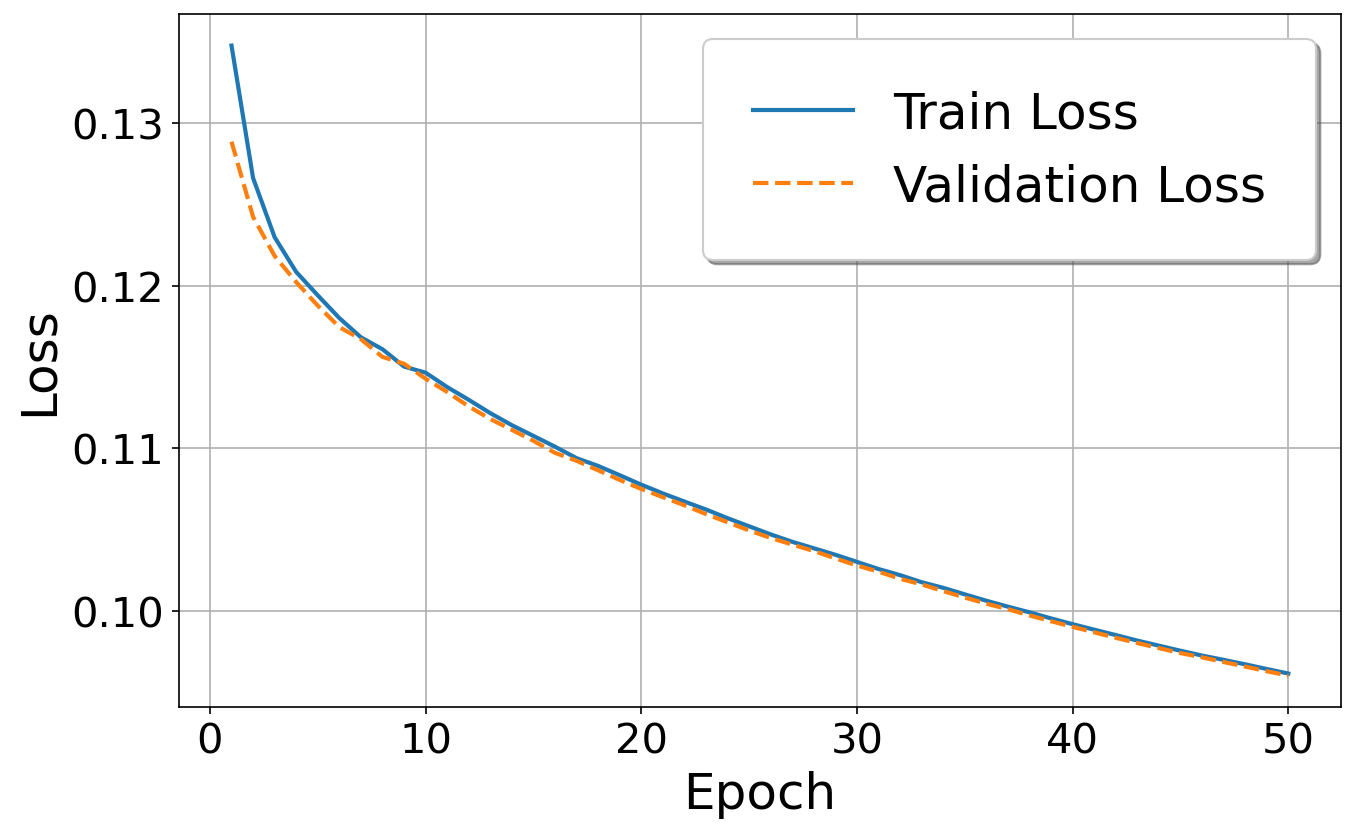

In [95]:

#loss_plots
loss_train_df = pd.read_csv(def_metric_dir.join("train_loss.csv"))
loss_train_df = loss_train_df.set_index("epoch")

loss_val_df = pd.read_csv(def_metric_dir.join("val_loss.csv"))
loss_val_df = loss_val_df.set_index("epoch")

plot_loss(loss_train_df, loss_val_df,10)


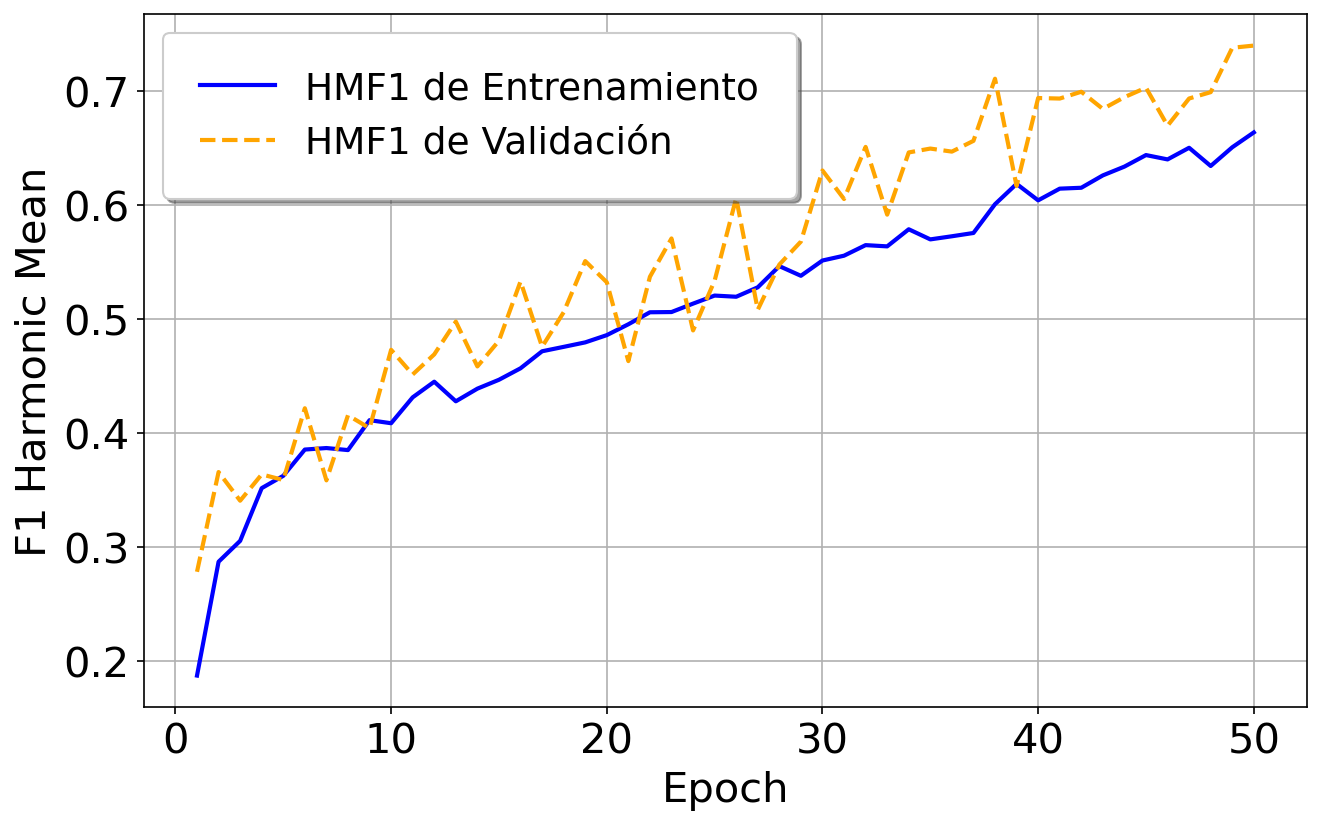

In [96]:
dmg_train_df = pd.read_csv(def_metric_dir.join("train_dmg_pixel_level.csv"))
dmg_val_df = pd.read_csv(def_metric_dir.join("val_dmg_pixel_level.csv"))

plot_harmonic_mean(dmg_train_df, dmg_val_df,10)

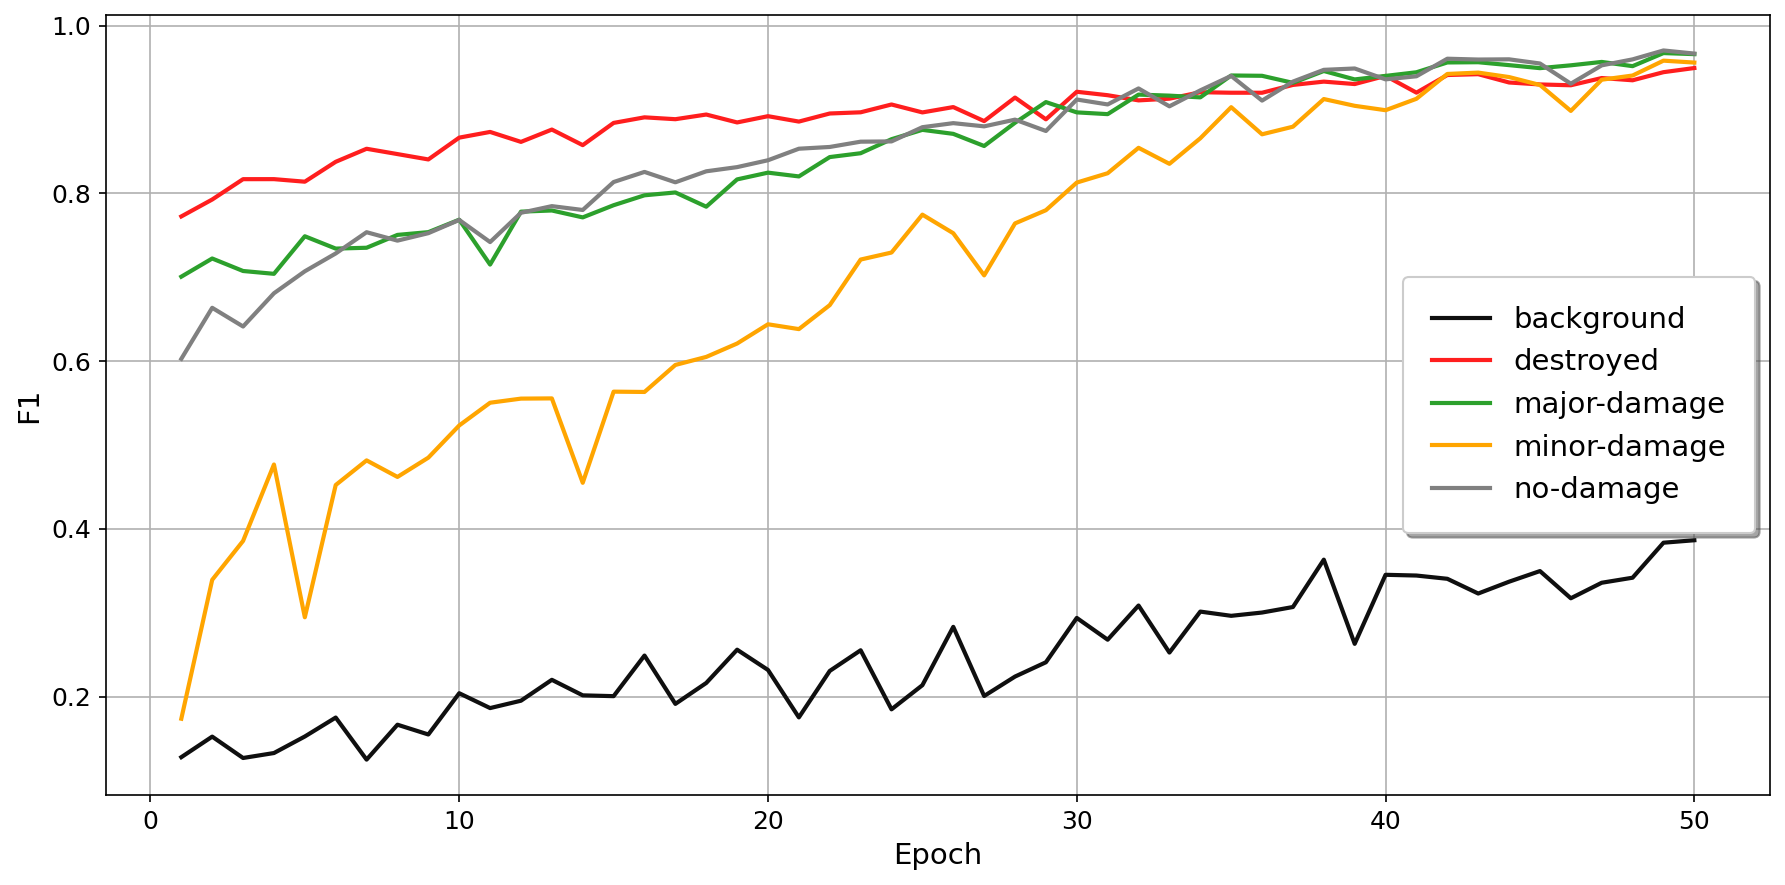

In [97]:
#val_f1_plots
from utils.visualization.label_to_color import LabelDict

dmg_val_df = pd.read_csv(def_metric_dir.join("val_dmg_pixel_level.csv"))

plot_metric_per_class(dmg_val_df, "f1",10)


### test metrics

In [98]:
test_metric_dir = path.join("definitive_model/best_metrics/csv")
bld_df = pd.read_csv(test_metric_dir.join("test_bld_pixel_level.csv"))
bld_df = bld_df.set_index(["epoch","class"])
bld_df

,,f1_harmonic_mean,precision,recall,f1,accuracy
epoch,class,,,,,
1,1,0.971935,1.0,0.945403,0.971935,0.996731


In [99]:
dmg_df = pd.read_csv(test_metric_dir.join("test_dmg_pixel_level.csv"))
dmg_df = dmg_df.set_index(["epoch","class"])
dmg_df

f1_harmonic_mean  precision    recall        f1  accuracy
epoch class                                                           
1     0              0.438444   0.160751  0.238864  0.192173  0.793414
      1              0.438444   0.704087  0.681142  0.692425  0.990718
      2              0.438444   0.452077  0.440373  0.446148  0.990408
      3              0.438444   0.738600  0.782133  0.759743  0.991725
      4              0.438444   0.911829  0.769055  0.834378  0.995567

In [100]:
loss_df = pd.read_csv(test_metric_dir.join("test_loss.csv"))
loss_df = loss_df.set_index(["epoch"])
loss_df

,loss
epoch,
1,0.111717


In [101]:
best_f1_hm = dmg_df["f1_harmonic_mean"].max()
test_loss = loss_df.iloc[0].iloc[0]
seg_f1 = bld_df["f1"].iloc[0]
print(best_epoch, best_f1_hm, test_loss, seg_f1)

50 0.4384437170044064 0.1117165285755287 0.9719351917450916


In [102]:
dmg_res_df = dmg_df.reset_index()
dmg_res_df["class"] = dmg_res_df["class"].apply(LabelDict().get_key_by_num)
dmg_res_df = dmg_res_df.drop(columns=["epoch"])
bld_res_df = bld_df.reset_index()
bld_res_df = bld_res_df.drop(columns=["epoch"])
bld_res_df["class"] = "is-building"
res_df = pd.concat([bld_res_df, dmg_res_df])
print("\multicolumn{2}{l}{Configuración "+f"{'?'}"+"} & \multicolumn{2}{l}{Mejor época "+f"{best_epoch}"+"} & \multicolumn{2}{r}{\emph{loss} = "+f"{val_loss}"+"} \\")
print(res_df.to_latex(index=False))

\multicolumn{2}{l}{Configuración ?} & \multicolumn{2}{l}{Mejor época 50} & \multicolumn{2}{r}{\emph{loss} = 0.0960215439381663} \
\begin{tabular}{lrrrrr}
\toprule
class & f1_harmonic_mean & precision & recall & f1 & accuracy \\
\midrule
is-building & 0.971935 & 1.000000 & 0.945403 & 0.971935 & 0.996731 \\
background & 0.438444 & 0.160751 & 0.238864 & 0.192173 & 0.793414 \\
no-damage & 0.438444 & 0.704087 & 0.681142 & 0.692425 & 0.990718 \\
minor-damage & 0.438444 & 0.452077 & 0.440373 & 0.446148 & 0.990408 \\
major-damage & 0.438444 & 0.738600 & 0.782133 & 0.759743 & 0.991725 \\
destroyed & 0.438444 & 0.911829 & 0.769055 & 0.834378 & 0.995567 \\
\bottomrule
\end{tabular}



# Experimento 5

In [103]:
path = FilePath("/home/mrtc101/Desktop/tesina/repo/prev_outs/exps/exp5_noh/exp5_noh/out")

In [104]:
wei_df = build_weights_table(path)
wei_df

,Class,Weight
0,background,2
1,no-damage,7
2,minor-damage,15
3,major-damage,14
4,destroyed,14


In [105]:
#pd.DataFrame.to_latex(index=False)
print(wei_df.to_latex(index=False))

\begin{tabular}{lr}
\toprule
Class & Weight \\
\midrule
background & 2 \\
no-damage & 7 \\
minor-damage & 15 \\
major-damage & 14 \\
destroyed & 14 \\
\bottomrule
\end{tabular}



In [106]:
params_df = build_conf_table(path)
params_df

,Number,Batch size,Learning rate,Total epochs
0,Config 0,16,0.001,200


In [107]:
print(params_df.to_latex(index=False))

\begin{tabular}{lrrr}
\toprule
Number & Batch size & Learning rate & Total epochs \\
\midrule
Config 0 & 16 & 0.001000 & 200 \\
\bottomrule
\end{tabular}



In [108]:
fold_df = build_fold_table(path)
fold_df = fold_df.sort_values(by=["Conf","Fold"])
fold_df = fold_df.groupby('Conf').apply(lambda x: x.set_index('Fold'), include_groups=False)
fold_df

,Fold,Best epoch,Harmonic-mean-f1,val-loss,Seg-f1
Conf,,,,,


In [109]:
print(fold_df.to_latex())

\begin{tabular}{llllll}
\toprule
 & Fold & Best epoch & Harmonic-mean-f1 & val-loss & Seg-f1 \\
Conf &  &  &  &  &  \\
\midrule
\bottomrule
\end{tabular}



### validation metrics

In [110]:
def_metric_dir = path.join("definitive_model/metrics/csv")
def_metric_dir

'/home/mrtc101/Desktop/tesina/repo/prev_outs/exps/exp5_noh/exp5_noh/out/definitive_model/metrics/csv'

In [111]:
bld_df, dmg_df, loss_df = load_dfs(def_metric_dir)
best_f1_hm = dmg_df["f1_harmonic_mean"].max()
best_epoch = dmg_df["f1_harmonic_mean"].idxmax()[0]
val_loss = loss_df.loc[best_epoch].iloc[0]
seg_f1 = bld_df.loc[best_epoch,"f1"].iloc[0]
print(best_epoch, best_f1_hm, val_loss, seg_f1)

193 0.8199184904119095 0.0863093596979328 0.9797254201327869


In [112]:
loss_df.loc[[best_epoch]]

,loss
epoch,
193,0.086309


In [113]:
print(loss_df.loc[[best_epoch]].to_latex())

\begin{tabular}{lr}
\toprule
 & loss \\
epoch &  \\
\midrule
193 & 0.086309 \\
\bottomrule
\end{tabular}



In [114]:
bld_df.loc[best_epoch]

,f1_harmonic_mean,precision,recall,f1,accuracy
class,,,,,
1,0.979725,1.0,0.960257,0.979725,0.998305


In [115]:
print(bld_df.loc[best_epoch].to_latex())

\begin{tabular}{lrrrrr}
\toprule
 & f1_harmonic_mean & precision & recall & f1 & accuracy \\
class &  &  &  &  &  \\
\midrule
1 & 0.979725 & 1.000000 & 0.960257 & 0.979725 & 0.998305 \\
\bottomrule
\end{tabular}



In [116]:
dmg_df.loc[best_epoch]

,f1_harmonic_mean,precision,recall,f1,accuracy
class,,,,,
0,0.819918,0.350985,0.861186,0.498714,0.763106
1,0.819918,0.995567,0.964124,0.979593,0.999518
2,0.819918,0.995593,0.954770,0.974754,0.999604
3,0.819918,0.996064,0.960362,0.977887,0.999417
4,0.819918,0.996144,0.958351,0.976882,0.999575


In [117]:
print(dmg_df.loc[best_epoch].to_latex())

\begin{tabular}{lrrrrr}
\toprule
 & f1_harmonic_mean & precision & recall & f1 & accuracy \\
class &  &  &  &  &  \\
\midrule
0 & 0.819918 & 0.350985 & 0.861186 & 0.498714 & 0.763106 \\
1 & 0.819918 & 0.995567 & 0.964124 & 0.979593 & 0.999518 \\
2 & 0.819918 & 0.995593 & 0.954770 & 0.974754 & 0.999604 \\
3 & 0.819918 & 0.996064 & 0.960362 & 0.977887 & 0.999417 \\
4 & 0.819918 & 0.996144 & 0.958351 & 0.976882 & 0.999575 \\
\bottomrule
\end{tabular}



In [118]:
dmg_res_df = dmg_df.loc[[best_epoch]].reset_index()
dmg_res_df["class"] = dmg_res_df["class"].apply(LabelDict().get_key_by_num)
dmg_res_df = dmg_res_df.drop(columns=["epoch"])
bld_res_df = bld_df.loc[[best_epoch]].reset_index()
bld_res_df = bld_res_df.drop(columns=["epoch"])
bld_res_df["class"] = "is-building"
res_df = pd.concat([bld_res_df, dmg_res_df])
print("\multicolumn{2}{l}{Configuración "+f"{'?'}"+"} & \multicolumn{2}{l}{Mejor época "+f"{best_epoch}"+"} & \multicolumn{2}{r}{\emph{loss} = "+f"{val_loss}"+"} \\")
print(res_df.to_latex(index=False))

\multicolumn{2}{l}{Configuración ?} & \multicolumn{2}{l}{Mejor época 193} & \multicolumn{2}{r}{\emph{loss} = 0.0863093596979328} \
\begin{tabular}{lrrrrr}
\toprule
class & f1_harmonic_mean & precision & recall & f1 & accuracy \\
\midrule
is-building & 0.979725 & 1.000000 & 0.960257 & 0.979725 & 0.998305 \\
background & 0.819918 & 0.350985 & 0.861186 & 0.498714 & 0.763106 \\
no-damage & 0.819918 & 0.995567 & 0.964124 & 0.979593 & 0.999518 \\
minor-damage & 0.819918 & 0.995593 & 0.954770 & 0.974754 & 0.999604 \\
major-damage & 0.819918 & 0.996064 & 0.960362 & 0.977887 & 0.999417 \\
destroyed & 0.819918 & 0.996144 & 0.958351 & 0.976882 & 0.999575 \\
\bottomrule
\end{tabular}



# Plot metrics over validation

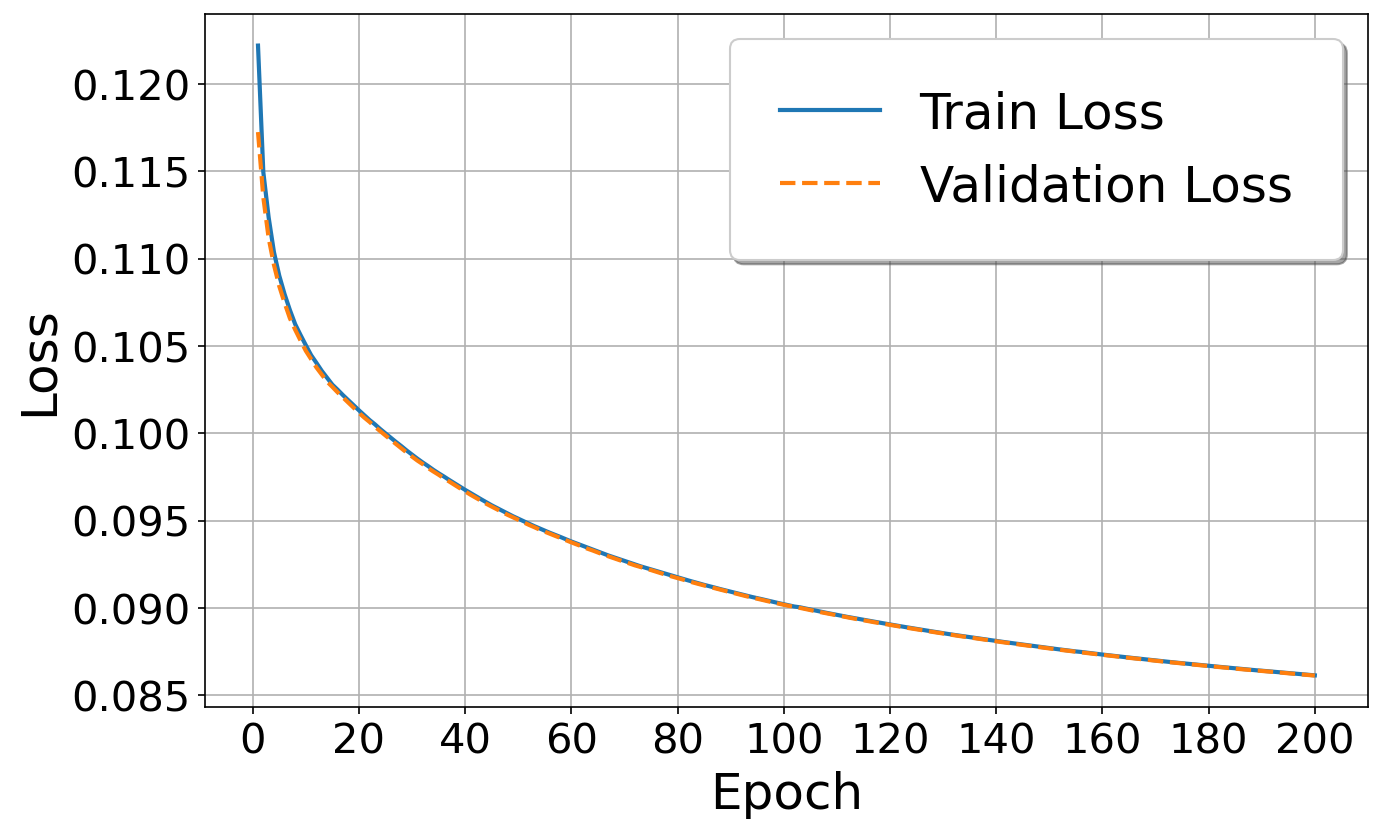

In [119]:

#loss_plots
loss_train_df = pd.read_csv(def_metric_dir.join("train_loss.csv"))
loss_train_df = loss_train_df.set_index("epoch")

loss_val_df = pd.read_csv(def_metric_dir.join("val_loss.csv"))
loss_val_df = loss_val_df.set_index("epoch")

plot_loss(loss_train_df, loss_val_df, 20)


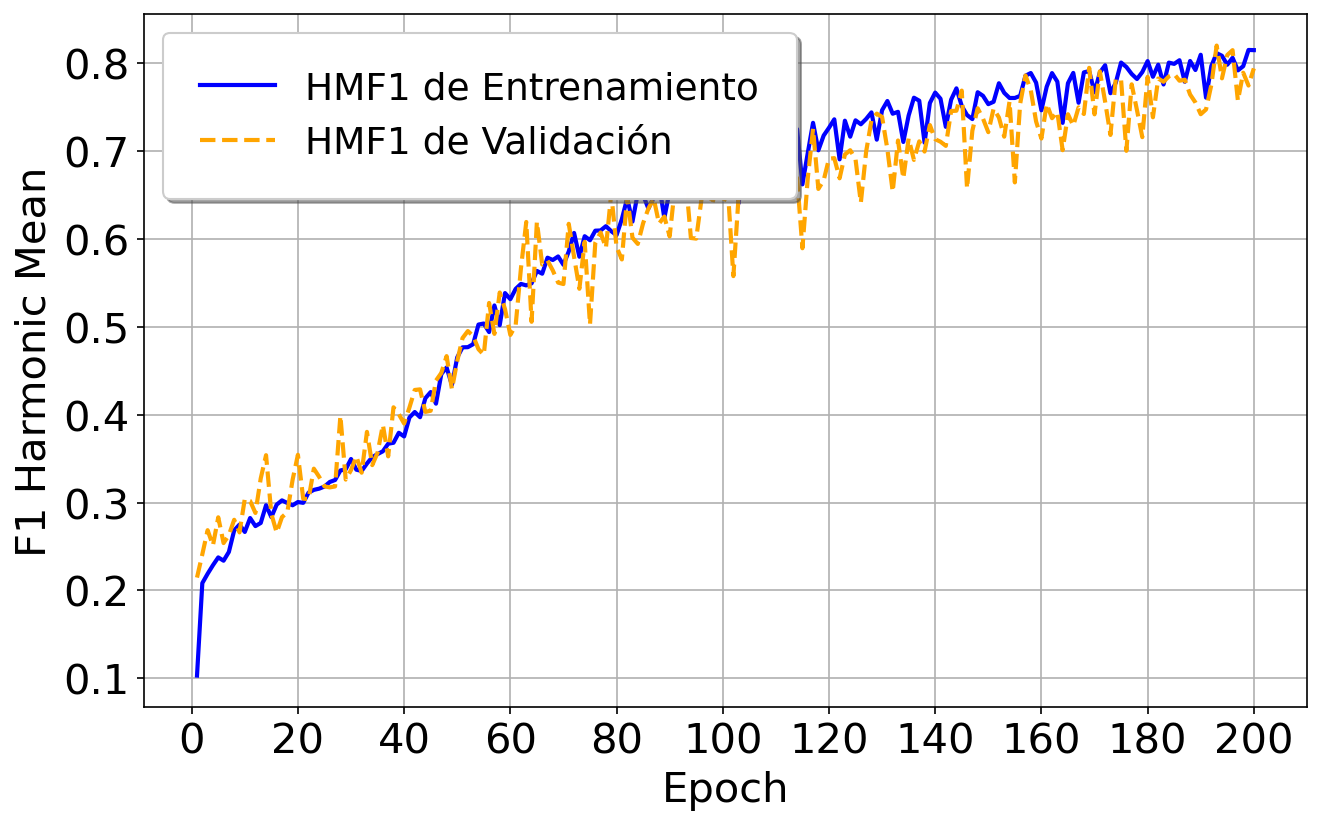

In [120]:
dmg_train_df = pd.read_csv(def_metric_dir.join("train_dmg_pixel_level.csv"))
dmg_val_df = pd.read_csv(def_metric_dir.join("val_dmg_pixel_level.csv"))

plot_harmonic_mean(dmg_train_df, dmg_val_df,20)

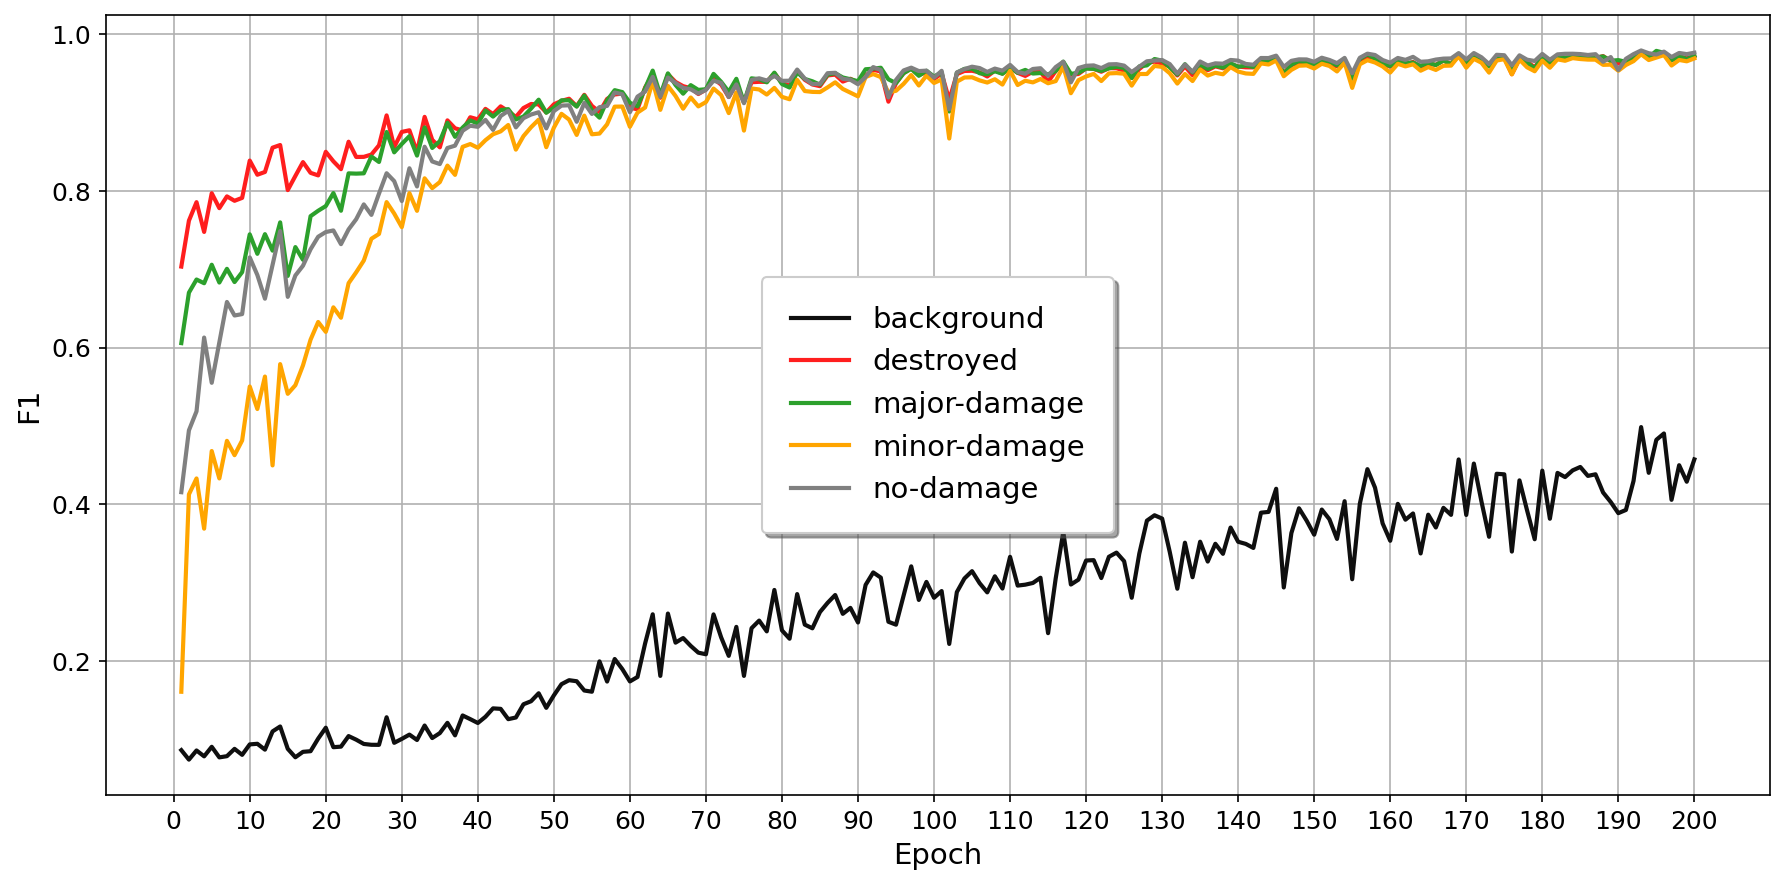

In [121]:
#val_f1_plots
from utils.visualization.label_to_color import LabelDict

dmg_val_df = pd.read_csv(def_metric_dir.join("val_dmg_pixel_level.csv"))

plot_metric_per_class(dmg_val_df, "f1",10)


### test metrics

In [122]:
test_metric_dir = path.join("definitive_model/best_metrics/csv")
bld_df = pd.read_csv(test_metric_dir.join("test_bld_pixel_level.csv"))
bld_df = bld_df.set_index(["epoch","class"])
bld_df

,,f1_harmonic_mean,precision,recall,f1,accuracy
epoch,class,,,,,
1,1,0.886897,1.0,0.79678,0.886897,0.990442


In [123]:
dmg_df = pd.read_csv(test_metric_dir.join("test_dmg_pixel_level.csv"))
dmg_df = dmg_df.set_index(["epoch","class"])
dmg_df

f1_harmonic_mean  precision    recall        f1  accuracy
epoch class                                                           
1     0               0.40961   0.098908  0.636944  0.171227  0.498794
      1               0.40961   0.773115  0.585230  0.666179  0.993137
      2               0.40961   0.711389  0.333628  0.454230  0.989921
      3               0.40961   0.681592  0.730824  0.705350  0.990906
      4               0.40961   0.857761  0.753853  0.802457  0.997272

In [124]:
loss_df = pd.read_csv(test_metric_dir.join("test_loss.csv"))
loss_df = loss_df.set_index(["epoch"])
loss_df

,loss
epoch,
1,0.126291


In [125]:
best_f1_hm = dmg_df["f1_harmonic_mean"].max()
test_loss = loss_df.iloc[0].iloc[0]
seg_f1 = bld_df["f1"].iloc[0]
print(best_epoch, best_f1_hm, test_loss, seg_f1)

193 0.4096099007387135 0.1262911526994271 0.8868974179715036


In [126]:
dmg_res_df = dmg_df.reset_index()
dmg_res_df["class"] = dmg_res_df["class"].apply(LabelDict().get_key_by_num)
dmg_res_df = dmg_res_df.drop(columns=["epoch"])
bld_res_df = bld_df.reset_index()
bld_res_df = bld_res_df.drop(columns=["epoch"])
bld_res_df["class"] = "is-building"
res_df = pd.concat([bld_res_df, dmg_res_df])
print("\multicolumn{2}{l}{Configuración "+f"{'?'}"+"} & \multicolumn{2}{l}{Mejor época "+f"{best_epoch}"+"} & \multicolumn{2}{r}{\emph{loss} = "+f"{val_loss}"+"} \\")
print(res_df.to_latex(index=False))

\multicolumn{2}{l}{Configuración ?} & \multicolumn{2}{l}{Mejor época 193} & \multicolumn{2}{r}{\emph{loss} = 0.0863093596979328} \
\begin{tabular}{lrrrrr}
\toprule
class & f1_harmonic_mean & precision & recall & f1 & accuracy \\
\midrule
is-building & 0.886897 & 1.000000 & 0.796780 & 0.886897 & 0.990442 \\
background & 0.409610 & 0.098908 & 0.636944 & 0.171227 & 0.498794 \\
no-damage & 0.409610 & 0.773115 & 0.585230 & 0.666179 & 0.993137 \\
minor-damage & 0.409610 & 0.711389 & 0.333628 & 0.454230 & 0.989921 \\
major-damage & 0.409610 & 0.681592 & 0.730824 & 0.705350 & 0.990906 \\
destroyed & 0.409610 & 0.857761 & 0.753853 & 0.802457 & 0.997272 \\
\bottomrule
\end{tabular}

